In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd


from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
%matplotlib notebook

In [3]:

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


# Test 1 dataset

In [4]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


# Set responsivity params

In [5]:
responsive_test = 'nstds'
responsive_thr = 10.0
n_stds = 2.5


# Get aggregated data

In [6]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
trace_type = optsE.trace_type
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

In [8]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
dsets = sdata[sdata['experiment']=='blobs']

In [9]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


In [10]:
sorted(dsets['animalid'].unique())

['JC076',
 'JC078',
 'JC080',
 'JC083',
 'JC084',
 'JC085',
 'JC090',
 'JC091',
 'JC097',
 'JC099',
 'JC110',
 'JC113',
 'JC117',
 'JC120']

# Select data

## IGNORE THESE:
##### V1:  JC076-20190501, JC083-20190510
    - if rfs only, ignore: JC083-20190510, JC083-20190511, 
    
    - if blobs & rfs only, ignore: JC083_20190510, JC083-20190511
    
    - if ALL stimuli, ignore: JC083-20190507, JC083-20190510, 
    
#### Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if rfs only, ignore: JC078-20190504, JC078-2019513, 
                           JC083-20190512

    - if blobs & rfs: ignore: JC078-20190426, JC078-2019513
                              JC083-20190512
                              
    - if ALL stimuli, ignore: JC078-20190430, JC078-20190426, JC078-20190504
                              JC083-20190508
#### Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [19]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                  'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']

also_exclude = ['JC083-20190510', 'JC083-20190511', 
                'JC078-20190426', 'JC078-2019513','JC083-20190512',
               'JC091-20191008']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

15


In [12]:
reload(util)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

# Create output dir for classification

In [13]:
outdir = os.path.join(aggregate_dir, 'blob-classification', stats_desc, 'test-generalization')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization


In [14]:
sessiondir = os.path.join(outdir, 'sessions')
if not os.path.exists(sessiondir):
    os.makedirs(sessiondir)

In [15]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [16]:
# Set plotting params
threshold_dff = True
min_dff = 0.03
cmap = 'inferno'
n_sz = 5
n_mp = 10

tune_name='morph'

incorrect_nvalues = []


In [17]:
dsets[dsets['animalid']=='JC091']

animalid experiment            fov   session visual_area
12    JC091      blobs  FOV1_zoom2p0x  20190627          Lm
16    JC091      blobs  FOV1_zoom2p0x  20191008          Li
22    JC091      blobs  FOV1_zoom2p0x  20190607          Li
26    JC091      blobs  FOV1_zoom2p0x  20190614          Li
30    JC091      blobs  FOV1_zoom2p0x  20190606          Li
35    JC091      blobs  FOV1_zoom2p0x  20190602          Li

In [20]:
R = {}
results={}

for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
    skey = '-'.join([animalid, session, fov])

    if '-'.join([animalid, session]) in excluded_sessions:
        print("...skipping %s" % skey)
        continue
        
    exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    # Get stimulus conditions
    sdf = exp.get_stimuli()
    sdf = reformat_morph_values(sdf)
    sizes = np.array(sorted(sdf['size'].unique()))
    morphs = np.array(sorted(sdf['morphlevel'].unique()))

    n_sizes = len(sdf['size'].unique())
    n_morphs = len(sdf['morphlevel'].unique()) 
    if n_sizes != n_sz or n_morphs != n_mp:
        incorrect_nvalues.append(skey)
        continue

    rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                 response_type=response_type, responsive_test=responsive_test,
                                 responsive_thr=responsive_thr, n_stds=n_stds)
    rstats = rstats['nframes_above']

    # Get metrics for each condition
    estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
    meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                       for roi in estats.rois], axis=1).T

    # Get ROI list
    if threshold_dff:
        rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
    else:
        rois_plot = meanr.index.tolist()
    print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

    #stimdf = sdf[sdf['morphlevel'] != -1]


    sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                          index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
    sample_data = sample_data[rois_plot]
    sample_labels = np.array(sample_data.index.tolist())

    sdf = exp.data.sdf.copy()
    sdf = reformat_morph_values(sdf)



    #stimdf = sdf[sdf['morphlevel'] != -1]
    stimdf = sdf.copy()
    tested_sizes = sorted(sdf['size'].unique())
    tested_morphs = sorted(sdf['morphlevel'].unique())

    #% Specify train/test conditions:     
    class_name = 'morphlevel'
    class_types = [0, 106]
    restrict_transform = True
    constant_transform = 'size'

    C = 1e3
    m0 = 0
    m100 = 106
    #train_transform = 30.

    size_colors = sns.cubehelix_palette(len(tested_sizes))
    lw=2

    for train_transform in tested_sizes:
        if train_transform not in R.keys():
            R[train_transform] = {}
            
        # Get train configs
        train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                & (stimdf[constant_transform]==train_transform))].index.tolist()
        
        # Get corresponding indices into data array
        train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

        # Get data and labels
        X = sample_data.iloc[train_ixs].values #[train_configs]
        y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

        # Select generalization-test set
        untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
        test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                               & (stimdf[class_name].isin(class_types)) )].index.tolist()

        test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
        X_test = sample_data.iloc[test_ixs].values
        y_test_labels = sample_labels[test_ixs]
        test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()


        #% Train/validation split
        n_splits = len(X)
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)

        scores=[]
        test_scores = dict((tv, []) for tv in tested_sizes)
        
        for train_index, validate_index in kf.split(X):
            # Get current train/validate split data
            X_train, X_validate = X[train_index], X[validate_index]
            y_train, y_validate = y[train_index], y[validate_index]
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train_transformed = scaler.transform(X_train)

            # Fit SVM
            trained_svc = LinearSVC(multi_class='ovr', C=C).fit(X_train_transformed, y_train)

            # Validate with held-out data
            X_validate_transformed = scaler.transform(X_validate)
            curr_score = trained_svc.score(X_validate_transformed, y_validate)  
            y_pred = trained_svc.predict(X_validate_transformed)
            
            # Add current fold score
            test_scores[train_transform].append(curr_score)

            # Test (generalization) to each size...
            for test_transform in test_transforms:
                curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                                 if stimdf[constant_transform][tl]==test_transform]
        
                X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
                y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
                curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
                
                test_scores[test_transform].append(curr_score_test)
                #print( test_transform, curr_score_test)
                #y_pred_test = trained_svc.predict(X_test_transformed)
    
#         fig, ax = pl.subplots()
#         xvals = sorted(tested_sizes)
#         meanscores = [np.mean(test_scores[k]) for k in tested_sizes]
#         semscores = [spstats.sem(test_scores[k]) for k in tested_sizes]
#         ax.plot(xvals, meanscores, marker='_', linewidth=0, color='k')
#         ax.errorbar(xvals, meanscores, yerr=semscores, ecolor='k', elinewidth=1, lw=0)
#         ax.set_xticks(tested_sizes)
#         ax.set_xticklabels(tested_sizes)
#         ax.set_ylim([0, 1])
#         ax.set_yticks(np.linspace(0, 1, 5))
#         ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 1, 5)])
#         sns.despine(ax=ax, trim=True, offset=4)
#         ax.set_xlabel('size')
#         ax.set_ylabel('accuracy')
#         label_figure(fig, data_id)
#         pl.savefig(os.path.join(sessiondir, '00_%s_%s_AvsB-LOO-train-size-%i.png' % (visual_area, skey, train_transform)))
#         pl.close()

        results[skey] = test_scores
        
        R[train_transform][skey] = test_scores


...skipping JC076-20190422-FOV1_zoom2p0x
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/blobs_run1/traces/traces001_bc0893/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/blobs_run2/traces/traces001_05b262/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/blobs_run3/traces/traces001_cdf7b0/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/blobs_run4/traces/traces001_2649ff/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/blobs_run5/traces/traces001_e62928/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/blobs_run6/traces/traces001_82b664/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e6292

adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/summary_stats/nstds/nstds_results.pkl']
Plotting 276 of 284 responsive cells.
...skipping JC091-20190606-FOV1_zoom2p0x
...skipping JC091-20190607-FOV1_zoom2p0x
... [JC091|20190614|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/blobs_run1/traces/traces001_1109ae/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/blobs_run2/traces/traces001_920e9d/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/blobs_run3/traces/traces001_8dceeb/data_arrays/datasets.

adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d86de1_traces001_8df9ce_traces001_61ca30_traces001_0266b8_traces001_111679_traces001_0abebe/summary_stats/nstds/nstds_results.pkl']
Plotting 119 of 121 responsive cells.
... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/blobs_run1/traces/traces001_94cb73/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/blobs_run2/traces/traces001_9d8a71/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/blobs_run3/traces/traces001_7a514c/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/blobs_run4/traces/traces001_864da3/data_arrays/datasets.npz', '/n/c

... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/summary_stats/nstds/nstds_results.pkl']
Plotting 21 of 82 responsive cells.
... [JC120|20191111|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/blobs_run1/traces/traces001_603e33/data_arrays/datasets.npz', '/n/c

... loading ROI stats: nstds
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_830af1_traces001_241385_traces001_4f577b_traces001_8a5bd2_traces001_af220b_traces001_f47906/summary_stats/nstds/nstds_results.pkl']
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_830af1_traces001_241385_traces001_4f577b_traces001_8a5bd2_traces001_af220b_traces001_f47906/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_830af1_traces001_241385_traces001_4f577b_traces001_8a5bd2_traces001_af220b_traces001_f47906/summary_stats/nstds/nstds_results.pkl']
Plotting 174 of 188 responsive cells.
...s

... loading ROI stats: nstds
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/summary_stats/nstds/nstds_results.pkl']
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/summary_stats/nstds/nstds_results.pkl']
Pl

... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/summary_stats/nstds/nstds_results.pkl']
Plotting 163 of 175 responsive cells.
...skipping JC076-20190501-FOV1_zoom2p0x
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/blobs_run1/traces/traces001_8afe5f/data_arrays/datasets.npz', '/

... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/summary_stats/nstds/nstds_results.pkl']
Plotting 197 of 202 responsive cells.
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/blobs_run1/traces/traces001_b92766/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC097/20190613/FOV1_zoo

... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/summary_stats/nstds/nstds_results.pkl']
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_tr

In [21]:
results_fn = os.path.join(outdir, 'results_train-size_test-generalization_AvB_LOO.pkl')

with open(results_fn, 'wb') as f:
    pkl.dump(R, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [22]:
results_fn

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization/results_train-size_test-generalization_AvB_LOO.pkl'

In [83]:
sessiondir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization/sessions'

In [17]:
trace_type = 'corrected'
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)

aggregate_stats_dir = os.path.join(aggregate_dir, 'responsivity', stats_desc)
if not os.path.exists(aggregate_stats_dir):
    os.makedirs(aggregate_stats_dir)
print(aggregate_stats_dir)

from pipeline.python.classifications import responsivity_stats as respstats


/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/stats-traces001-corrected-dff-nstds-thr-10.00


/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/summaries
creating new session object...
[JC113] 20191018 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
found 4 experiments
Calculating stats
[rfs10] Loading roi lists...
('Session Object- Getting grouped roi stats: exp is', 'rfs10')
('... found loaded experiments: ', [])
... no experiment data saved, loading now...
... Loading data (rfs10 - traces001 - corrected)
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC113|20191018|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... loading data array
/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_15997b_traces001_657cb8_traces001_35c9c0_traces001_59f68b/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
... ... loaded traces
... rfs10: calcu

<IPython.core.display.Javascript object>


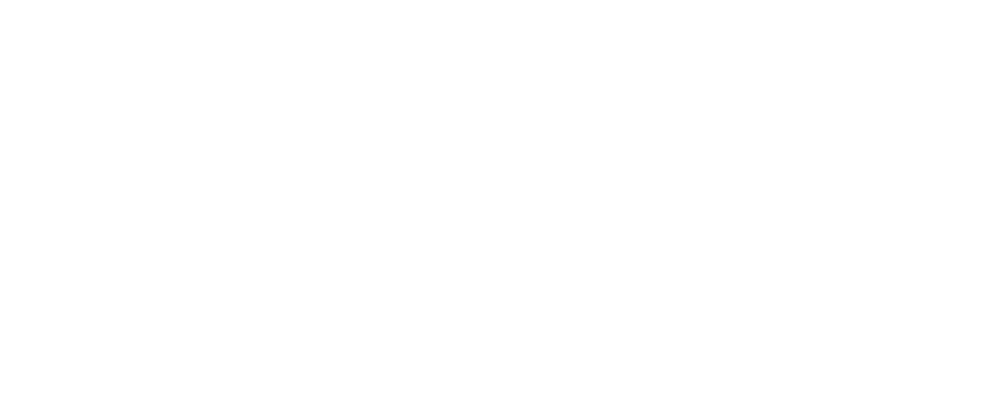

blobs
gratings
rfs10
--- done! ---


In [24]:
visual_area = 'Li'
animalid = 'JC113'
session = '20191018'
fov = 'FOV1_zoom2p0x'
skey = '%s_%s' % (visual_area, '-'.join([animalid, session, fov]))
create_new=True
plot_rois=True

nostats = respstats.visualize_session_stats(animalid, session, fov, 
                                         create_new=create_new, altdir=aggregate_stats_dir, 
                                         traceid=traceid, trace_type=trace_type,
                                         plot_rois=plot_rois,
                                         response_type=response_type, 
                                         responsive_test=responsive_test,
                                         responsive_thr=responsive_thr,
                                         n_stds = n_stds)


In [32]:
import datetime


In [40]:
datetime.datetime.now()
datetime.datetime.now().strftime("%d-%b-%Y")

'03-Feb-2020'

In [42]:
datestr = datetime.datetime.now().strftime("%d-%b-%Y")
print(datestr)

03-Feb-2020


In [19]:
datestr = '20191211'

# Set colors

In [26]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot performance generalization for each dataset

In [ ]:
from matplotlib.pyplot import cm
sns.set_style('ticks')
#color=iter(cm.rainbow(np.linspace(0,1,50)))

fig, axes = pl.subplots(len(tested_sizes), 3, figsize=(8,15), sharex=True, sharey=True)
xvals = sorted(tested_sizes)

for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
    skey = '-'.join([animalid, session, fov])
    
    for si in range(len(tested_sizes)):
        curr_results = R[tested_sizes[si]]
        train_ix = si
        if skey not in curr_results.keys():
            continue
        test_scores = curr_results[skey].copy()

        ai = visual_areas.index(visual_area)
        ax = axes[si, ai]
        if si == 0:
            ax.set_title(visual_area)

        ax.set_xticks(tested_sizes)
        ax.set_xticklabels(tested_sizes)
        ax.set_ylim([0, 1])
        ax.set_yticks(np.linspace(0, 1, 5))
        ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 1, 5)])
        
        meanscores = [np.mean(test_scores[k]) for k in tested_sizes]
        semscores = [spstats.sem(test_scores[k]) for k in tested_sizes]
        ax.plot(xvals, meanscores, marker='_', linewidth=0, alpha=0.5, color='k')
        ax.errorbar(xvals, meanscores, yerr=semscores, alpha=0.5, 
                    color='k', ecolor='k', elinewidth=1, lw=1)
        ax.plot(tested_sizes[train_ix], meanscores[train_ix], 'ro', alpha=0.8, markersize=3)
        
        ax.axhline(y=0.5, linestyle=':', lw=1, color='k')

pl.subplots_adjust(wspace=0.2, hspace=0.2)
sns.despine(trim=True, offset=2)
pl.savefig(os.path.join(outdir, 'by-session_AvB_train-1-size-test-others_%s.png' % datestr))
pl.savefig(os.path.join(outdir, 'by-session_AvB_train-1-size-test-others_%s.svg' % datestr))

<IPython.core.display.Javascript object>


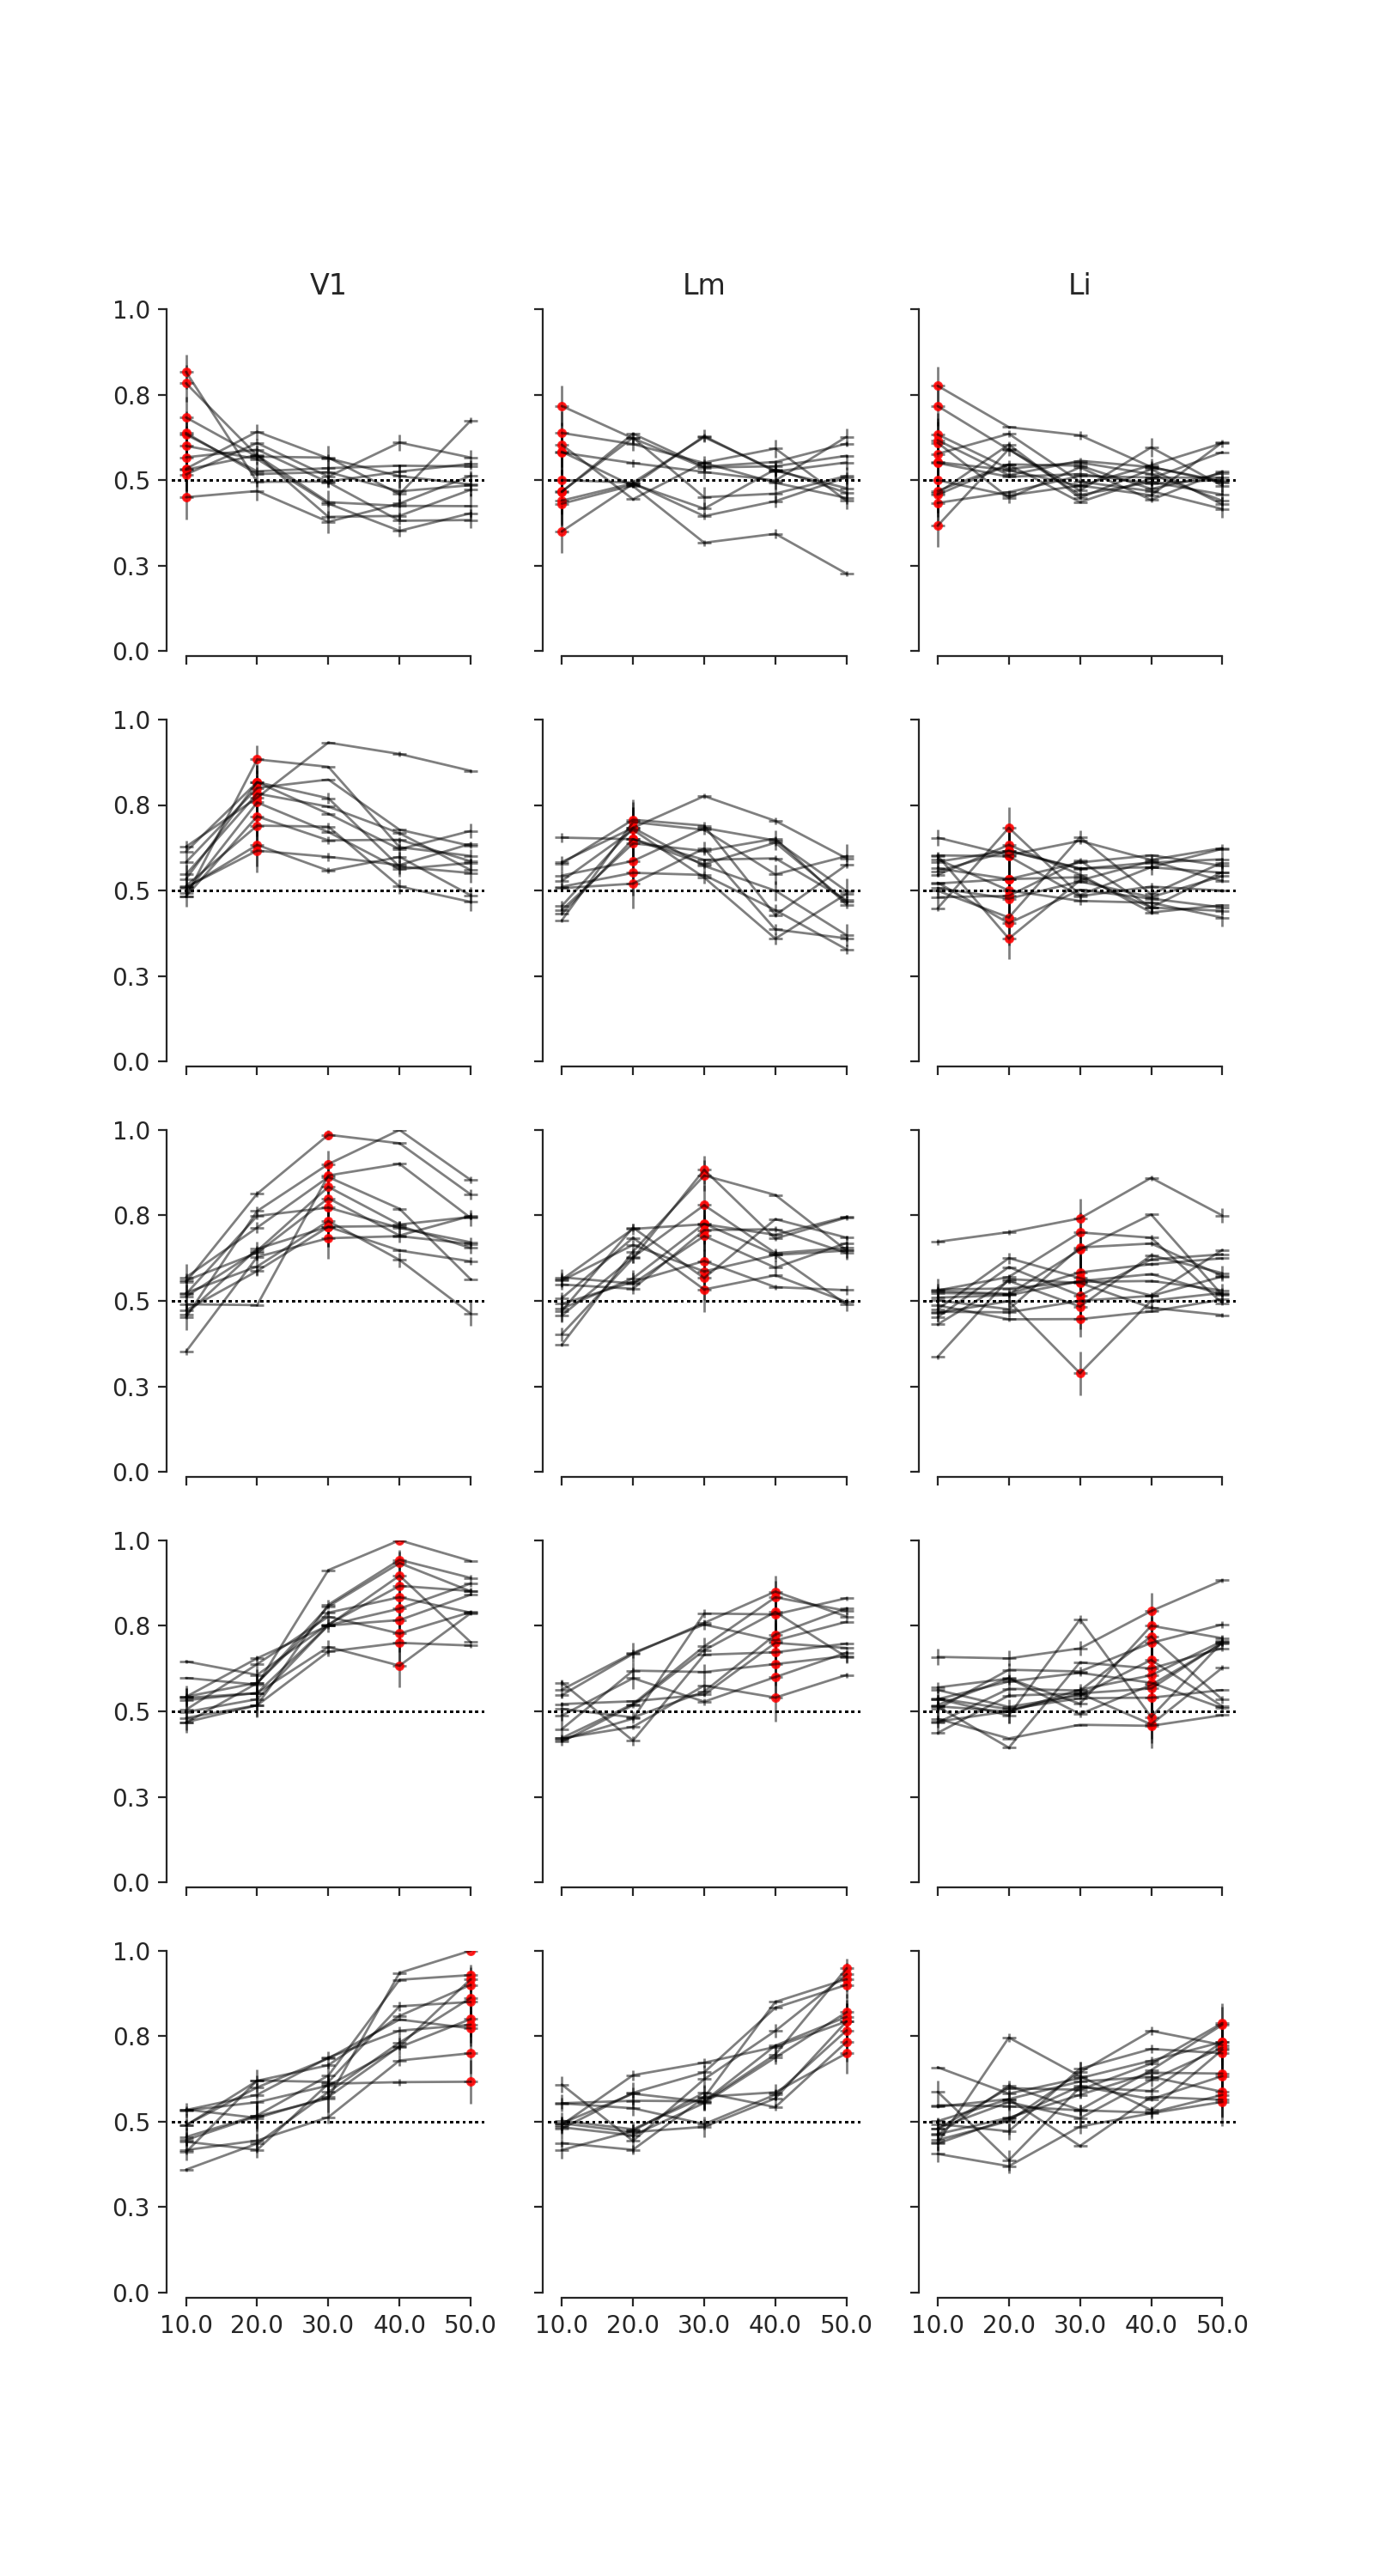

In [20]:
from matplotlib.pyplot import cm
sns.set_style('ticks')
#color=iter(cm.rainbow(np.linspace(0,1,50)))


fig, axes = pl.subplots(len(tested_sizes), 3, figsize=(8,15), sharex=True, sharey=True)
xvals = sorted(tested_sizes)

for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
    skey = '-'.join([animalid, session, fov])
    
    for si in range(len(tested_sizes)):
        curr_results = R[tested_sizes[si]]
        train_ix = si
        if skey not in curr_results.keys():
            continue
        test_scores = curr_results[skey].copy()

        ai = visual_areas.index(visual_area)
        ax = axes[si, ai]
        if si == 0:
            ax.set_title(visual_area)

        ax.set_xticks(tested_sizes)
        ax.set_xticklabels(tested_sizes)
        ax.set_ylim([0, 1])
        ax.set_yticks(np.linspace(0, 1, 5))
        ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 1, 5)])
        
        meanscores = [np.mean(test_scores[k]) for k in tested_sizes]
        semscores = [spstats.sem(test_scores[k]) for k in tested_sizes]
        ax.plot(xvals, meanscores, marker='_', linewidth=0, alpha=0.5, color='k')
        ax.errorbar(xvals, meanscores, yerr=semscores, alpha=0.5, 
                    color='k', ecolor='k', elinewidth=1, lw=1)
        ax.plot(tested_sizes[train_ix], meanscores[train_ix], 'ro', alpha=0.8, markersize=3)
        
        ax.axhline(y=0.5, linestyle=':', lw=1, color='k')

pl.subplots_adjust(wspace=0.2, hspace=0.2)
sns.despine(trim=True, offset=2)
pl.savefig(os.path.join(outdir, 'by-session_AvB_train-1-size-test-others_%s.png' % datestr))
pl.savefig(os.path.join(outdir, 'by-session_AvB_train-1-size-test-others_%s.svg' % datestr))

In [26]:
meanscores['V1']

array([[0.44138889, 0.4175    , 0.61083333, 0.61555556, 0.61666667],
       [0.41694444, 0.44472222, 0.51305556, 0.67888889, 0.7       ],
       [0.44638889, 0.51611111, 0.56777778, 0.935     , 1.        ],
       [0.45510204, 0.51836735, 0.63469388, 0.91489796, 0.92857143],
       [0.53555556, 0.51083333, 0.57222222, 0.72027778, 0.91666667],
       [0.48916667, 0.61944444, 0.665     , 0.80916667, 0.9       ],
       [0.53388889, 0.57861111, 0.68722222, 0.76611111, 0.78333333],
       [0.41083333, 0.62055556, 0.61583333, 0.8375    , 0.85      ],
       [0.5325    , 0.55666667, 0.60555556, 0.71777778, 0.8       ],
       [0.35969084, 0.43608799, 0.58650416, 0.73127229, 0.86206897],
       [0.49012856, 0.60009183, 0.68503214, 0.7986685 , 0.77272727]])

In [28]:
meanvs

[0.49012855831037655,
 0.6000918273645547,
 0.6850321395775942,
 0.7986685032139579,
 0.7727272727272727]

In [24]:
visual_areas = ['V1', 'Lm', 'Li']

<IPython.core.display.Javascript object>


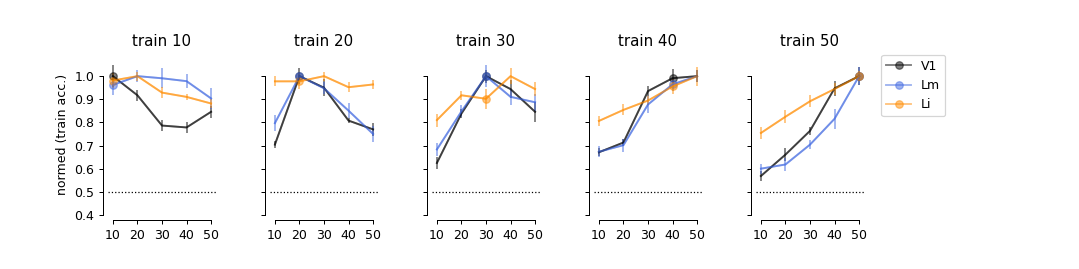

by-visual-area__AvB_train-1-size-test-others_03-Feb-2020normalized


In [58]:
norm_to_trained = True

fig, axes = pl.subplots(1, len(tested_sizes), figsize=(12,3), sharex=True, sharey=True)

for si in range(len(tested_sizes)):
    curr_results = R[tested_sizes[si]]
    ax = axes[si]

    meanscores = dict((visual_area, []) for visual_area in visual_areas)
    for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):

        data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
        skey = '-'.join([animalid, session, fov])

        if skey not in results.keys():
            continue
        test_scores = curr_results[skey]
        meanvs = [np.mean(test_scores[k]) for k in tested_sizes]
        meanscores[visual_area].append(meanvs)

    for visual_area in visual_areas:
        meanscores[visual_area] = np.array(meanscores[visual_area])
        means = meanscores[visual_area].mean(axis=0)
        sems = spstats.sem(meanscores[visual_area], axis=0)

        if norm_to_trained:
            means = means / means.max()
            ylabel = 'normed (train acc.)'
        else:
            ylabel = 'accuracy'
    #     for si in range(meanscores[visual_area].shape[0]):
    #         ax.scatter(tested_sizes, meanscores[visual_area][si, :], c=area_colors[visual_area],s=5)
        ax.plot(tested_sizes, means, color=area_colors[visual_area], alpha=0.5)
        ax.plot(tested_sizes[si], means[si], color=area_colors[visual_area], marker='o', label=visual_area, alpha=0.5)
        ax.errorbar(tested_sizes, means, yerr=sems, color=area_colors[visual_area], alpha=0.5)

        ax.set_ylim([0.4, 1.1])
        ax.set_xticks(tested_sizes)
        ax.set_yticks([round(v, 1) for v in np.linspace(0.4, 1.0, 7)])
        #ax.set_
        ax.set_xticklabels([int(i) for i in tested_sizes])
        sns.despine(ax=ax, trim=True, offset=4)
    ax.set_title('train %i' % tested_sizes[si])
    ax.axhline(y=0.5, linestyle=':', lw=1, color='k')
    if si == 0:
        ax.set_ylabel(ylabel)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1, right=0.8, bottom=0.2)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.8))
normstr = 'normalized' if norm_to_trained else ''

figname = 'by-visual-area__AvB_train-1-size-test-others_%s%s' % (datestr, normstr)
print(figname)

pl.savefig(os.path.join(outdir, '%s.png' % figname)) 
pl.savefig(os.path.join(outdir, '%s.svg' % figname))


In [44]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization'

In [23]:
meanscores = dict((visual_area, []) for visual_area in visual_areas)
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
    skey = '-'.join([animalid, session, fov])
    
    if skey not in results.keys():
        continue
    test_scores = results[skey]
    

    meanvs = [np.mean(test_scores[k]) for k in tested_sizes]
    meanscores[visual_area].append(meanvs)

for visual_area in visual_areas:
    meanscores[visual_area] = np.array(meanscores[visual_area])

<IPython.core.display.Javascript object>


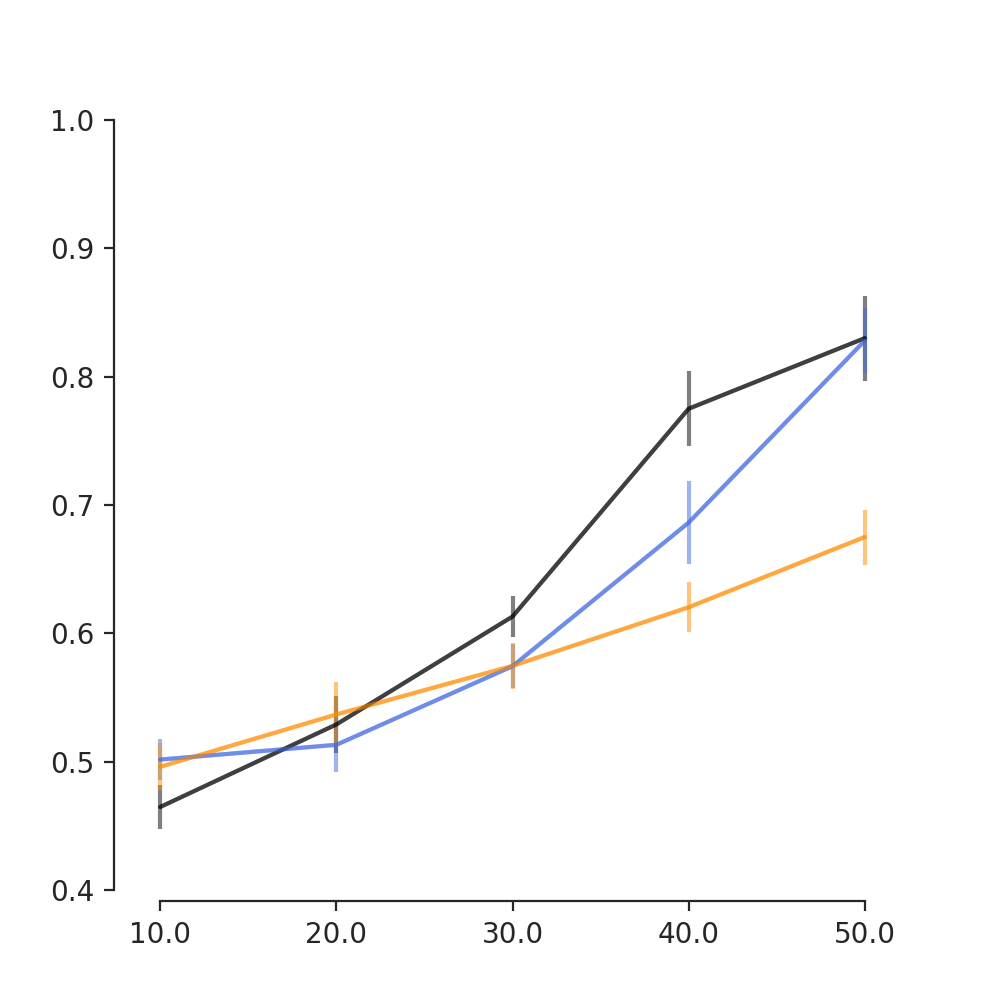

In [24]:
fig, ax = pl.subplots(figsize=(5,5))

for visual_area in visual_areas:
    means = meanscores[visual_area].mean(axis=0)
    sems = spstats.sem(meanscores[visual_area], axis=0)
    
#     for si in range(meanscores[visual_area].shape[0]):
#         ax.scatter(tested_sizes, meanscores[visual_area][si, :], c=area_colors[visual_area],s=5)
    ax.plot(tested_sizes, means, color=area_colors[visual_area], alpha=0.5)
    ax.errorbar(tested_sizes, means, yerr=sems, color=area_colors[visual_area], alpha=0.5)
    
ax.set_ylim([0.4, 1])
ax.set_xticks(tested_sizes)
ax.set_xticklabels(tested_sizes)
sns.despine(ax=ax, trim=True, offset=4)

pl.savefig(os.path.join(outdir, 'average_generalize-across-size_train-size-50-new-all_%s.svg' % datestr))

In [34]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization'

# RFECV

In [59]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [36]:
# The "accuracy" scoring is proportional to the number of correct
# classifications
svc = LinearSVC(multi_class='ovr', C=C) #.fit(X_train_transformed, y_train)

#n_splits = len(X)
#kf = KFold(n_splits=n_splits)
kf = StratifiedKFold(5)    
    
X = sample_data.iloc[train_ixs].values.copy() #[train_configs]
y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

rfecv = RFECV(estimator=svc, step=1, cv=kf, scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

<IPython.core.display.Javascript object>


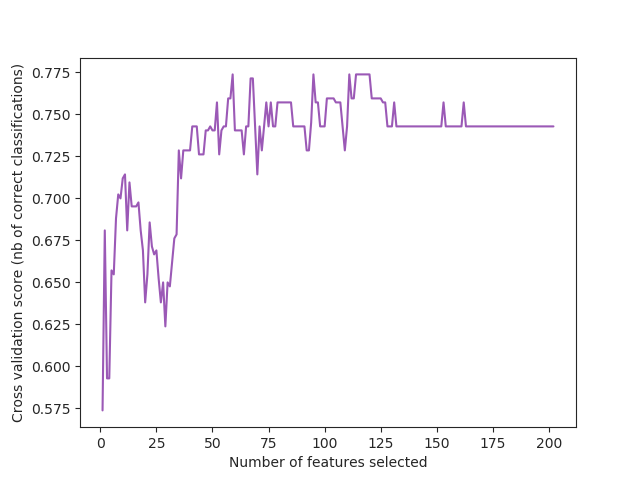

In [37]:
# Plot number of features VS. cross-validation scores
fig, ax = pl.subplots()
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)


In [38]:
visual_areas = ['V1', 'Lm', 'Li']

In [60]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization'

In [ ]:
do_rfe = False

rfe_fpath = os.path.join(os.path.split(outdir)[0], 'rfe-results-LOO.pkl')
if os.path.exists(rfe_fpath):
    rfe_results = pkl.load(f)
else:
    do_rfe = True
    

In [61]:
if do_rfe:
rfe_results = dict((visual_area, dict()) for visual_area in visual_areas)
for visual_area in visual_areas:
    
    sessions = dsets[ dsets['visual_area'] == visual_area ]
    n_datasets = sessions.shape[0]
    
    #thresh_str = 'thr-%.2f' % min_dff if threshold_dff else 'no-thr'
    #sfilename = os.path.join(aggr_stats_dir, '%s_%s_%s-%s.pkl' % (visual_area, experiment_type, response_type, thresh_str))
    #print("Stats: %s" % os.path.split(sfilename)[-1])


    ai = 0
    #ai = 0
    for (animalid, session, fov), g in sessions.groupby(['animalid', 'session', 'fov']):
        
        skey = '-'.join([animalid, session, fov])
        data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

        if '-'.join([animalid, session]) in excluded_sessions:
            print("...skipping %s" % skey)
            continue

        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        tested_sizes = np.array(sorted(sdf['size'].unique()))
        tested_morphs = np.array(sorted(sdf['morphlevel'].unique()))

        n_sizes = len(sdf['size'].unique())
        n_morphs = len(sdf['morphlevel'].unique()) 
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            continue


        # Get metrics for each condition
        estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T

        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                              index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
        sample_data = sample_data[rois_plot]
        sample_labels = np.array(sample_data.index.tolist())


        #stimdf = sdf[sdf['morphlevel'] != -1]
        stimdf = sdf.copy()

        #% Specify train/test conditions:     
        class_name = 'morphlevel'
        class_types = [0, 106]
        restrict_transform = True
        constant_transform = 'size'

        Cval = 1e3
        m0 = 0
        m100 = 106
        #fig, ax = pl.subplots()

        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2

        res = []
        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2
        pdict = dict()
        for curr_sz, curr_color in zip(tested_sizes, size_colors):

            if restrict_transform:
                constant_transform_val = curr_sz
                train_configs = stimdf[((stimdf[class_name].isin(class_types)) & (stimdf[constant_transform]==constant_transform_val))].index.tolist()
            else:
                train_configs = stimdf[stimdf[class_name].isin(class_types)].index.tolist()

            # Set train/test set:
            train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

            X = sample_data.iloc[train_ixs].values #[train_configs]
            y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

            # The "accuracy" scoring is proportional to the number of correct
            # classifications
            svc = LinearSVC(multi_class='ovr', C=Cval) #.fit(X_train_transformed, y_train)

            #n_splits = len(X)
            #kf = KFold(n_splits=n_splits)
            kf = StratifiedKFold(5)    

            rfecv = RFECV(estimator=svc, step=1, cv=kf, scoring='accuracy')
            rfecv.fit(X, y)            
            
            res.append((curr_sz, rfecv.grid_scores_))
        
        rfe_results[visual_area][skey] = res

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/blobs_run1/traces/traces001_5ffca7/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/blobs_run2/traces/traces001_09c921/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/blobs_run3/traces/traces001_512e96/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/blobs_run4/traces/traces001_394d78/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/blobs_run5/traces/traces001_64e684/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/blobs_run6/traces/traces001_6bacb1/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/datasets.n

Plotting 168 of 180 responsive cells.
... [JC085|20190622|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/blobs_run1/traces/traces001_6da5ed/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/blobs_run2/traces/traces001_19b5de/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/blobs_run3/traces/traces001_565a1c/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/blobs_run4/traces/traces001_238b5b/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/blobs_run5/traces/traces001_cb35ec/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/blobs_run6/traces/traces001_6537ce/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_t

adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/summary_stats/nstds/nstds_results.pkl']
Plotting 266 of 276 responsive cells.
... [JC110|20191006|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/blobs_run1/traces/traces001_3b3744/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/blobs_run2/traces/traces001_1990cb/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/blobs_run3/traces/traces001_58a59f/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/blobs_run4/traces/traces001

adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC078/20190504/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_830af1_traces001_241385_traces001_4f577b_traces001_8a5bd2_traces001_af220b_traces001_f47906/summary_stats/nstds/nstds_results.pkl']
Plotting 174 of 188 responsive cells.
...skipping JC078-20190509-FOV1_zoom2p0x
... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/blobs_run1/traces/traces001_23404b/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/blobs_run2/traces/traces001_f36dbe/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/blobs_run3/traces/traces001_ece5a1/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/blobs_run4/traces/traces00

adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/summary_stats/nstds/nstds_results.pkl']
Plotting 161 of 171 responsive cells.
...skipping JC083-20190512-FOV1_zoom2p0x
...skipping JC083-20190517-FOV1_zoom2p0x
... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run1/traces/traces001_dea723/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run2/traces/traces001_8cef6c/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run3/traces/traces001_abf256/data_arrays/datasets.

adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190502/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_bc0893_traces001_05b262_traces001_cdf7b0_traces001_2649ff_traces001_e62928_traces001_82b664/summary_stats/nstds/nstds_results.pkl']
Plotting 142 of 148 responsive cells.
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/blobs_run1/traces/traces001_5afb30/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/blobs_run2/traces/traces001_ea6bc7/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/blobs_run3/traces/traces001_9747d8/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/blobs_run4/traces/traces001

adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_traces001_7c7a76_traces001_cc90dc_traces001_344475/summary_stats/nstds/nstds_results.pkl']
Plotting 262 of 263 responsive cells.
...skipping JC091-20191008-FOV1_zoom2p0x
... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/blobs_run1/traces/traces001_2be711/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/blobs_run2/traces/traces001_333f6c/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/blobs_run3/traces/traces001_31bd42/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/blobs_run4/traces/traces00

adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_45d7bf_traces001_9d98af_traces001_e6dd0f_traces001_af8efe_traces001_53b0c3_traces001_48b222_traces001_5a33cb_traces001_636e28_traces001_9675ee_traces001_c992b1_traces001_deae7e/summary_stats/nstds/nstds_results.pkl']
Plotting 69 of 69 responsive cells.
... [JC117|20191105|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
('FOUND RUNS:', ['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/blobs_run1/traces/traces001_1621ed/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/blobs_run2/traces/traces001_99712e/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/blobs_run3/traces/traces001_498354/data_arrays/datasets.npz', '/n/coxfs01/2p-data/JC117/2019110

In [63]:
rfe_fpath = os.path.join(os.path.split(outdir)[0], 'rfe-results-LOO.pkl')
print(rfe_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/rfe-results-LOO.pkl


In [64]:
with open(rfe_fpath, 'wb') as f:
    pkl.dump(rfe_results, f, protocol=pkl.HIGHEST_PROTOCOL)
    
    
    

In [140]:
[v.shape for k, v in scores]

[(21,), (21,), (21,), (21,), (21,)]

In [148]:
np.array([v for k, v in scores]).mean(axis=0).shape

(21,)

In [101]:
scores

[(10.0, array([ 0.51666667,  0.46666667,  0.45      ,  0.43333333,  0.51666667,
          0.48333333,  0.48333333,  0.5       ,  0.5       ,  0.48333333,
          0.5       ,  0.5       ,  0.5       ,  0.48333333,  0.53333333,
          0.55      ,  0.58333333,  0.61666667,  0.61666667,  0.58333333,
          0.56666667,  0.55      ,  0.56666667,  0.56666667,  0.58333333,
          0.56666667,  0.58333333,  0.56666667,  0.56666667,  0.55      ,
          0.51666667,  0.48333333,  0.5       ,  0.51666667,  0.55      ,
          0.53333333,  0.5       ,  0.51666667,  0.55      ,  0.6       ,
          0.58333333,  0.58333333,  0.55      ,  0.55      ,  0.55      ,
          0.56666667,  0.56666667,  0.56666667,  0.53333333,  0.53333333,
          0.56666667,  0.58333333,  0.58333333,  0.56666667,  0.56666667,
          0.56666667,  0.6       ,  0.63333333,  0.61666667,  0.61666667,
          0.65      ,  0.61666667,  0.61666667,  0.63333333,  0.65      ,
          0.63333333,  0.6166666

<IPython.core.display.Javascript object>


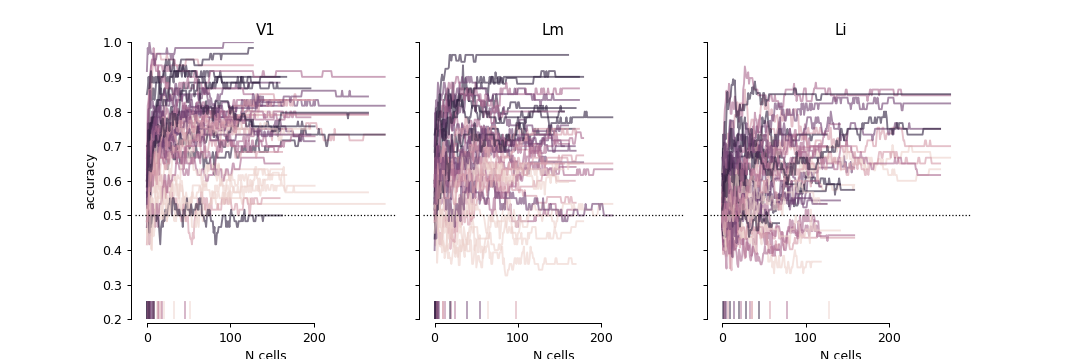

1 10.0 168
1 20.0 168
1 30.0 168
1 40.0 168
1 50.0 168
2 10.0 286
2 20.0 286
2 30.0 286
2 40.0 286
2 50.0 286
3 10.0 160
3 20.0 160
3 30.0 160
3 40.0 160
3 50.0 160
4 10.0 128
4 20.0 128
4 30.0 128
4 40.0 128
4 50.0 128
5 10.0 202
5 20.0 202
5 30.0 202
5 40.0 202
5 50.0 202
6 10.0 163
6 20.0 163
6 30.0 163
6 40.0 163
6 50.0 163
7 10.0 197
7 20.0 197
7 30.0 197
7 40.0 197
7 50.0 197
8 10.0 266
8 20.0 266
8 30.0 266
8 40.0 266
8 50.0 266
1 10.0 169
1 20.0 169
1 30.0 169
1 40.0 169
1 50.0 169
2 10.0 179
2 20.0 179
2 30.0 179
2 40.0 179
2 50.0 179
3 10.0 170
3 20.0 170
3 30.0 170
3 40.0 170
3 50.0 170
4 10.0 161
4 20.0 161
4 30.0 161
4 40.0 161
4 50.0 161
5 10.0 174
5 20.0 174
5 30.0 174
5 40.0 174
5 50.0 174
6 10.0 214
6 20.0 214
6 30.0 214
6 40.0 214
6 50.0 214
7 10.0 156
7 20.0 156
7 30.0 156
7 40.0 156
7 50.0 156
1 10.0 159
1 20.0 159
1 30.0 159
1 40.0 159
1 50.0 159
2 10.0 274
2 20.0 274
2 30.0 274
2 40.0 274
2 50.0 274
3 10.0 119
3 20.0 119
3 30.0 119
3 40.0 119
3 50.0 119
4 10.0 142

In [106]:
visual_area = 'V1'
all_sdicts = {}
fig, axes = pl.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, visual_area in zip(axes.flat, visual_areas):
    res = rfe_results[visual_area]

    sdict = dict((sz, []) for sz in tested_sizes)
    for skey, scores in res.items():
        for i, (sz, acc) in enumerate(scores):
            si = list(tested_sizes).index(sz)
            sdict[sz].append(acc)
            print len(sdict[sz]), sz, len(acc)
            ax.plot(range(len(acc)), acc, color=size_colors[si], alpha=0.6)

            acc_thr = np.where(acc>=0.7)[0]
            if len(acc_thr) > 0:
                acc_thr_val = int(acc_thr[0])
                ax.plot([acc_thr_val, acc_thr_val], [0, 0.25], color=size_colors[si], alpha=0.5)
        
    ax.set_title(visual_area)
    all_sdicts[visual_area] = sdict
    
    
for ai, ax in enumerate(axes.flat):
    ax.set_ylim([0.2, 1])
    ax.axhline(y=0.5, linestyle=':', linewidth=1, alpha=1, color='k')
    sns.despine(trim=True, offset=3)
    ax.set_xlabel('N cells')
    if ai==0:
        ax.set_ylabel('accuracy')

pl.subplots_adjust(wspace=0.1)

figname = 'RFEC-plot-each-size_linearSVM-AvsB_stratified-5-fold_test'
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [89]:
scores[0][1].shape

(168,)

In [77]:
len(res[res.keys()[0]])

5

In [100]:
for k, v in sdict.items():
    print k, len(v)

 40.0 10
10.0 10
20.0 10
50.0 10
30.0 10


In [110]:
len(acc_values)


8

#### Plot 1 color

<IPython.core.display.Javascript object>


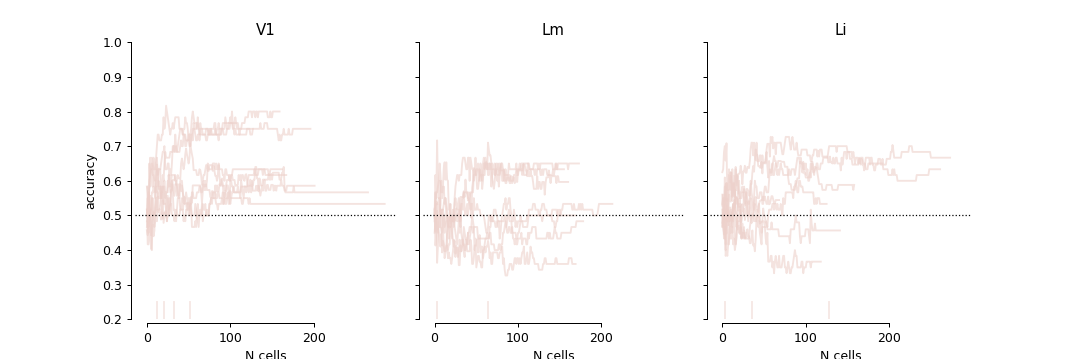

In [118]:
curr_sz = 10

fig, axes = pl.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, visual_area in zip(axes.flat, visual_areas):

    sdict = all_sdicts[visual_area]

    for sz, acc_by_dset in sdict.items():
        if sz != curr_sz:
            continue
        si = list(tested_sizes).index(sz)
        #print skey, len(acc)
        #acc = sdict[sz]
        for acc_values in acc_by_dset:
            ax.plot(range(len(acc_values)), acc_values, color=size_colors[si], alpha=0.6)

            acc_thr = np.where(acc_values>=0.7)[0]
            if len(acc_thr) > 0:
                acc_thr_val = int(acc_thr[0])
                ax.plot([acc_thr_val, acc_thr_val], [0, 0.25], color=size_colors[si], alpha=0.5)

    ax.set_title(visual_area)
    
    
for ai, ax in enumerate(axes.flat):
    ax.set_ylim([0.2, 1])
    ax.axhline(y=0.5, linestyle=':', linewidth=1, alpha=1, color='k')
    sns.despine(trim=True, offset=3)
    ax.set_xlabel('N cells')
    if ai==0:
        ax.set_ylabel('accuracy')

pl.subplots_adjust(wspace=0.1)

figname = 'RFEC-plot-size-%i_linearSVM-AvsB_stratified-5-fold' % (curr_sz)
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [113]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/test-generalization'

### Average over sizes

<IPython.core.display.Javascript object>


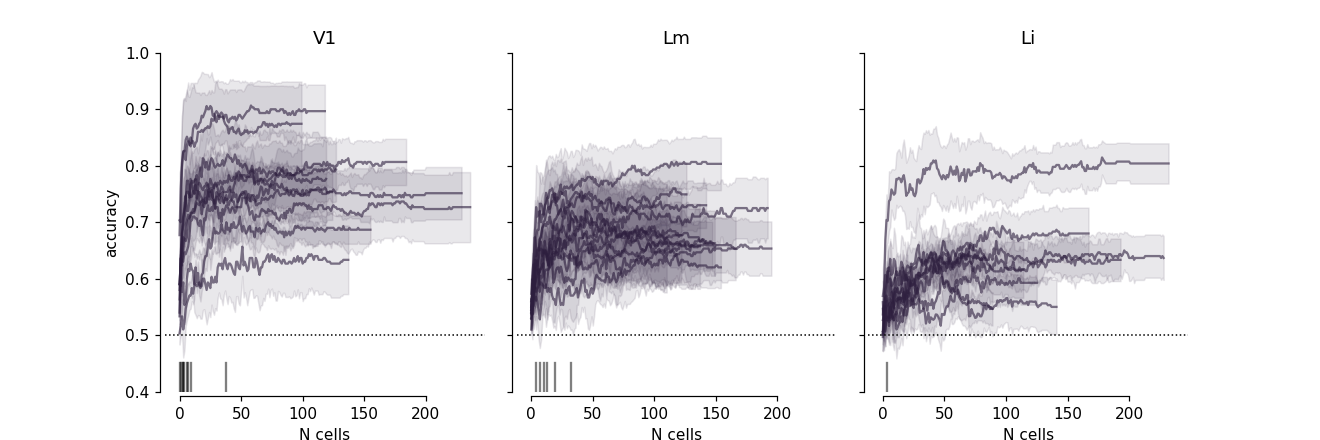

In [188]:
visual_area = 'V1'

fig, axes = pl.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, visual_area in zip(axes.flat, visual_areas):
    res = rfe_results[visual_area]

    for skey, scores in res.items():
        mean_score = np.array([v for k, v in scores]).mean(axis=0)
        sem_score = spstats.sem(np.array([v for k, v in scores]), axis=0)
        ax.plot(range(len(mean_score)), mean_score, color=size_colors[si], alpha=0.6)
        ax.fill_between(range(len(mean_score)), mean_score+sem_score,
                        mean_score-sem_score, color=size_colors[si], alpha=0.1)
        
        acc_thr = np.where(mean_score>=0.7)[0]
        if len(acc_thr) > 0:
            acc_thr_val = int(acc_thr[0])
            ax.plot([acc_thr_val, acc_thr_val], [0, 0.45], color='k', alpha=0.5)
        
    ax.set_title(visual_area)
    
for ai, ax in enumerate(axes.flat):
    ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, linestyle=':', linewidth=1, alpha=1, color='k')
    sns.despine(trim=True, offset=3)
    ax.set_xlabel('N cells')
    if ai==0:
        ax.set_ylabel('accuracy')

pl.subplots_adjust(wspace=0.1)

figname = 'RFEC-average-across-size_linearSVM-AvsB_stratified-5-fold'
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [175]:
np.where(mean_score>=0.7)

(array([], dtype=int64),)

In [164]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00'

<IPython.core.display.Javascript object>


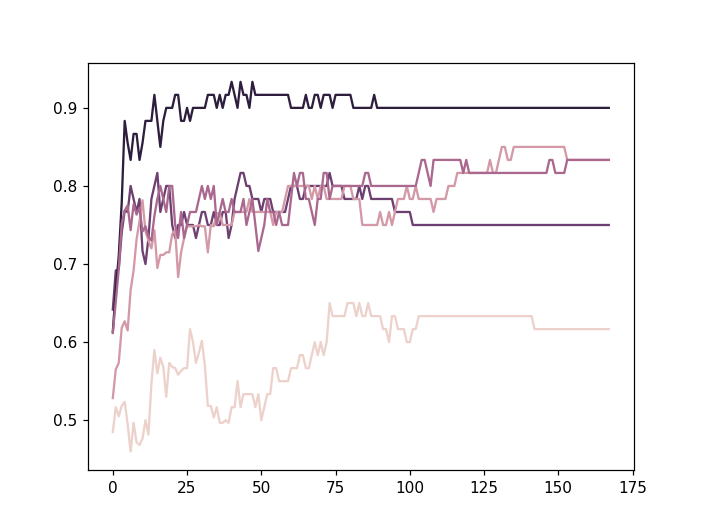

In [133]:
fig, ax = pl.subplots()
for sz, arrl in sdict.items():
    sdict[sz] = np.array(arrl) # n_datasets x n_rois
    si = list(tested_sizes).index(sz)
    nr = sdict[sz].shape[-1]
    mean_scores =  sdict[sz].mean(axis=0)
    sem_scores = sdict[sz].std(axis=0)
    
    ax.plot(range(nr), mean_scores, color=size_colors[si])
    #ax.fill_between(range(nr), sdict[sz].mean(axis=0), color=size_colors[si])

(168,)

In [30]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())

In [31]:
print tested_sizes

[10.0, 20.0, 30.0, 40.0, 50.0]


In [32]:
print tested_morphs

[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]


In [122]:
size_colors

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [15]:
if not os.path.exists(os.path.join(outdir, 'sessions')):
    os.makedirs(os.path.join(outdir, 'sessions'))
print(os.path.join(outdir, 'sessions'))

/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00/sessions


# Get aggregate stats

In [100]:
experiment_type = 'blobs'
aggr_tcourse_dir = os.path.join(aggregate_dir, 'data-stats', 'experiment-objects', experiment_type)
aggr_stats_dir = os.path.join(aggregate_dir, 'data-stats', stats_desc)

if not os.path.exists(aggr_tcourse_dir):
    os.makedirs(aggr_tcourse_dir)
if not os.path.exists(aggr_stats_dir):
    os.makedirs(aggr_stats_dir)

In [101]:
visual_areas = ['V1', 'Lm', 'Li']

In [102]:
tested_morphs

[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]

In [103]:
stimdf

color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
config006                0  Blob_N1  10.0    image    20    -8    0
config007                0  Blob_N1  20.0    image    20    -8    0
config008                0  Blob_N1  30.0    image    20    -8    0
config009                0  Blob_N1  40.0    image    20    -8    0
config010                0  Blob_N1  50.0    image    20    -8    0
config011               14  morph14  10.0    image    20    -8    0
config012               14  morph14  20.0    image    20    -8    0
config013               14  morph14  30.0    image    20    -8    0
config014               14  morph14  40.0    image    20    -8    0
config015               14  morph14  50.0    image    20    -8    0
config016               27  morph27  10.0    image    20    -8    0
config017               27  morph27  20.0    image    20    -8    0
config018               27  morph27  30.0    image    20    -8    0
config019               27  morph27  40.0    image    20    -8    0
config020               27  morph27  50.0    image    20    -8    0
config021               40  morph40  10.0    image    20    -8    0
config022               40  morph40  20.0    image    20    -8    0
config023               40  morph40  30.0    image    20    -8    0
config024               40  morph40  40.0    image    20    -8    0
config025               40  morph40  50.0    image    20    -8    0
config026               53  morph53  10.0    image    20    -8    0
config027               53  morph53  20.0    image    20    -8    0
config028               53  morph53  30.0    image    20    -8    0
config029               53  morph53  40.0    image    20    -8    0
config030               53  morph53  50.0    image    20    -8    0
config031               66  morph66  10.0    image    20    -8    0
config032               66  morph66  20.0    image    20    -8    0
config033               66  morph66  30.0    image    20    -8    0
config034               66  morph66  40.0    image    20    -8    0
config035               66  morph66  50.0    image    20    -8    0
config036               79  morph79  10.0    image    20    -8    0
config037               79  morph79  20.0    image    20    -8    0
config038               79  morph79  30.0    image    20    -8    0
config039               79  morph79  40.0    image    20    -8    0
config040               79  morph79  50.0    image    20    -8    0
config041               92  morph92  10.0    image    20    -8    0
config042               92  morph92  20.0    image    20    -8    0
config043               92  morph92  30.0    image    20    -8    0
config044               92  morph92  40.0    image    20    -8    0
config045               92  morph92  50.0    image    20    -8    0
config046              106  Blob_N2  10.0    image    20    -8    0
config047              106  Blob_N2  20.0    image    20    -8    0
config048              106  Blob_N2  30.0    image    20    -8    0
config049              106  Blob_N2  40.0    image    20    -8    0
config050              106  Blob_N2  50.0    image    20    -8    0

# Classify morphs LOO at each size

Stats: V1_blobs_dff-thr-0.03.pkl
['JC076-20190501-FOV1_zoom2p0x', 'JC084-20190522-FOV1_zoom2p0x', 'JC097-20190616-FOV1_zoom2p0x', 'JC097-20190613-FOV1_zoom2p0x', 'JC083-20190507-FOV1_zoom2p0x', 'JC083-20190511-FOV1_zoom2p0x', 'JC076-20190420-FOV1_zoom2p0x', 'JC083-20190510-FOV1_zoom2p0x', 'JC085-20190622-FOV1_zoom2p0x', 'JC097-20190617-FOV1_zoom2p0x']


<IPython.core.display.Javascript object>


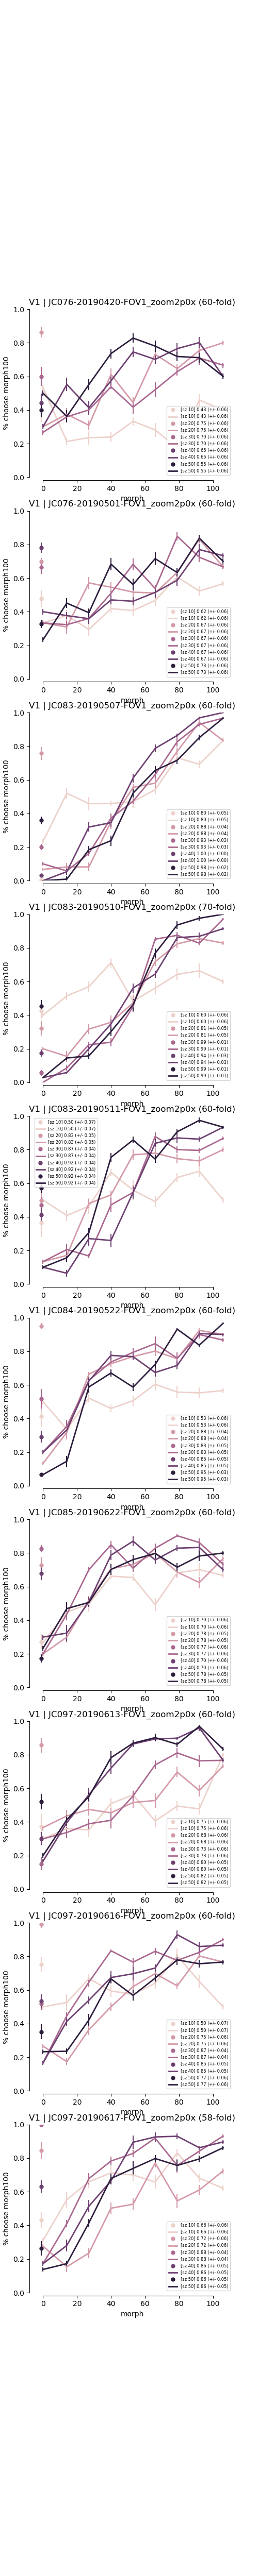

<IPython.core.display.Javascript object>


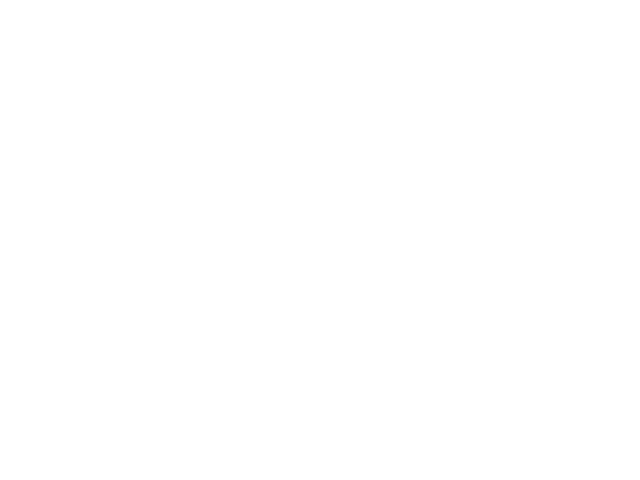

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC076-20190420-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 138 of 175 responsive cells.
mean score: 0.43 (+/- 0.06)
mean score: 0.75 (+/- 0.06)
mean score: 0.70 (+/- 0.06)
mean score: 0.65 (+/- 0.06)
mean score: 0.55 (+

<IPython.core.display.Javascript object>


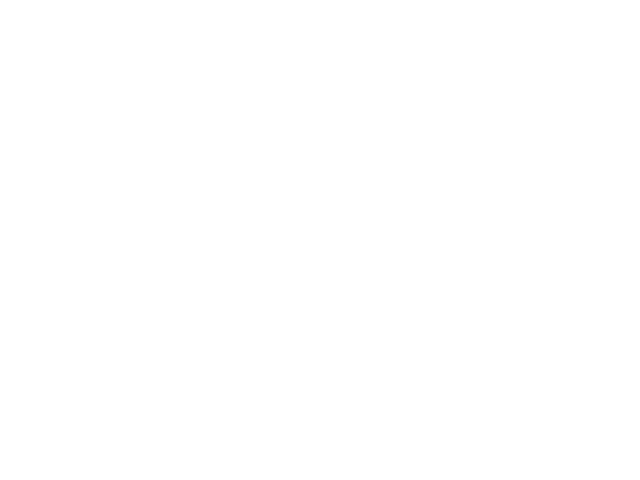

... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC076-20190501-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 156 of 189 responsive cells.
mean score: 0.62 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.73 (+

<IPython.core.display.Javascript object>


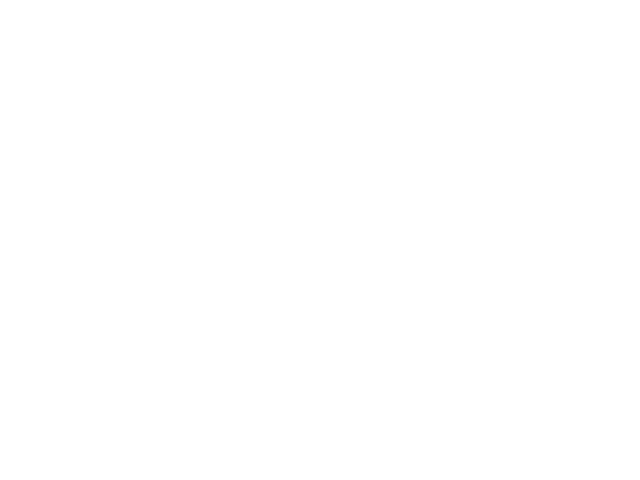

... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC083-20190507-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 119 of 132 responsive cells.
mean score: 0.80 (+/- 0.05)
mean score: 0.88 (+/- 0.04)
mean score: 0.93 (+/- 0.03)
mean score: 1.00 (+/- 0.00)
mean score: 0.98 (+

<IPython.core.display.Javascript object>


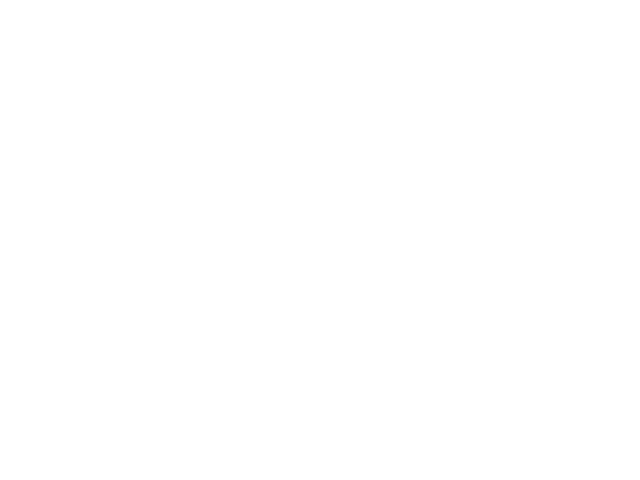

... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC083-20190510-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 100 of 121 responsive cells.
mean score: 0.60 (+/- 0.06)
mean score: 0.81 (+/- 0.05)
mean score: 0.99 (+/- 0.01)
mean score: 0.94 (+/- 0.03)
mean score: 0.99 (+

<IPython.core.display.Javascript object>


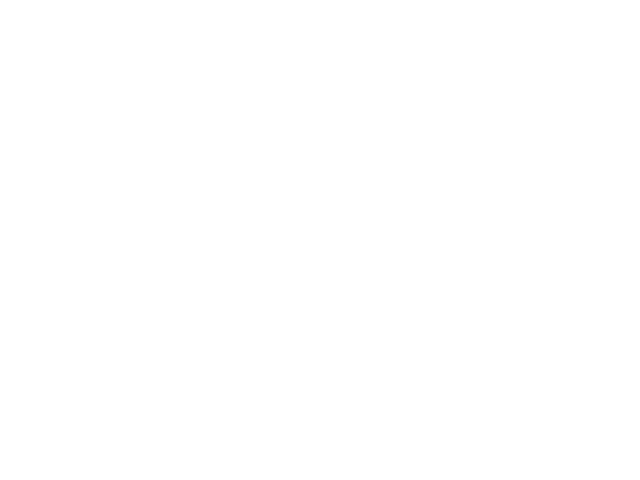

... [JC083|20190511|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC083-20190511-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 120 of 126 responsive cells.
mean score: 0.50 (+/- 0.07)
mean score: 0.83 (+/- 0.05)
mean score: 0.87 (+/- 0.04)
mean score: 0.92 (+/- 0.04)
mean score: 0.92 (+

<IPython.core.display.Javascript object>


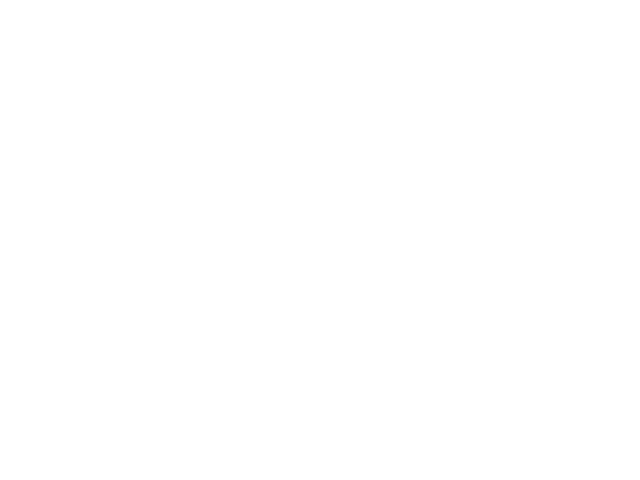

... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC084-20190522-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 128 of 180 responsive cells.
mean score: 0.53 (+/- 0.06)
mean score: 0.88 (+/- 0.04)
mean score: 0.83 (+/- 0.05)
mean score: 0.85 (+/- 0.05)
mean score: 0.95 (+

<IPython.core.display.Javascript object>


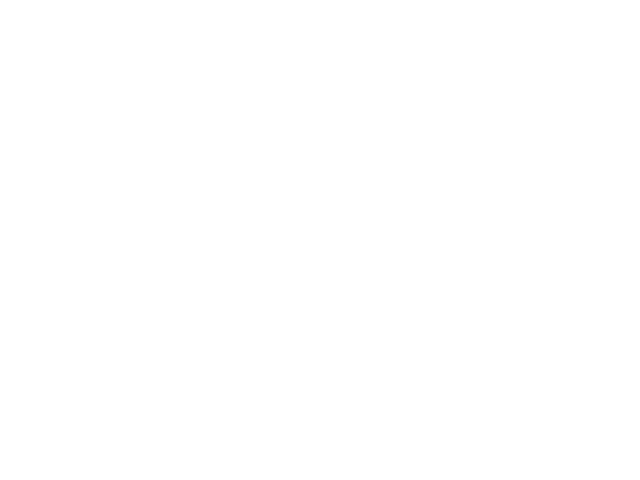

... [JC085|20190622|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC085-20190622-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 185 of 202 responsive cells.
mean score: 0.70 (+/- 0.06)
mean score: 0.78 (+/- 0.05)
mean score: 0.77 (+/- 0.06)
mean score: 0.70 (+/- 0.06)
mean score: 0.78 (+

<IPython.core.display.Javascript object>


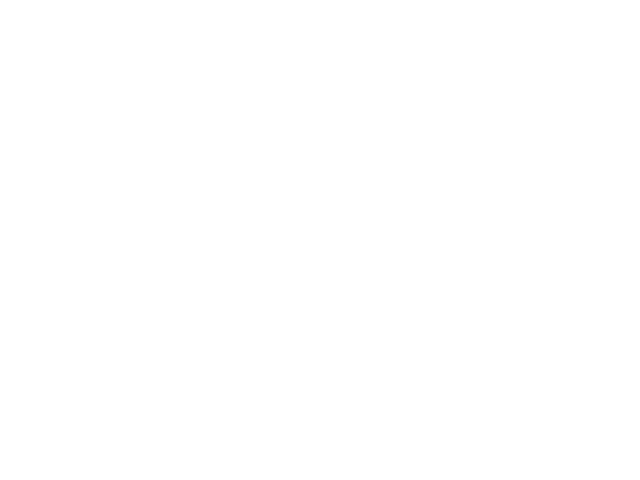

... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC097-20190613-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 125 of 166 responsive cells.
mean score: 0.75 (+/- 0.06)
mean score: 0.68 (+/- 0.06)
mean score: 0.73 (+/- 0.06)
mean score: 0.80 (+/- 0.05)
mean score: 0.82 (+

<IPython.core.display.Javascript object>


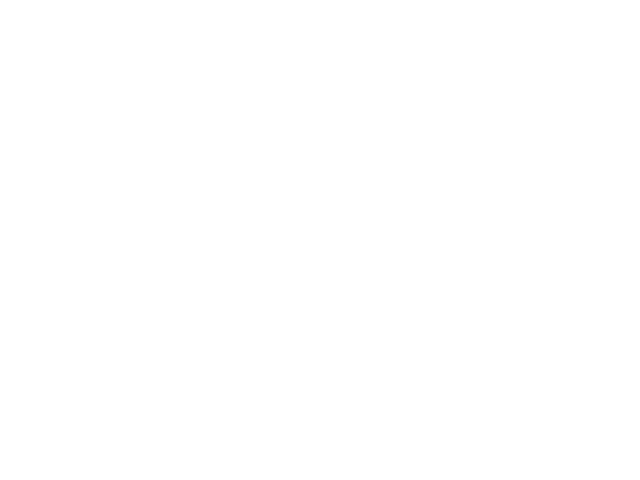

... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC097-20190616-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 237 of 298 responsive cells.
mean score: 0.50 (+/- 0.07)
mean score: 0.75 (+/- 0.06)
mean score: 0.87 (+/- 0.04)
mean score: 0.85 (+/- 0.05)
mean score: 0.77 (+

<IPython.core.display.Javascript object>


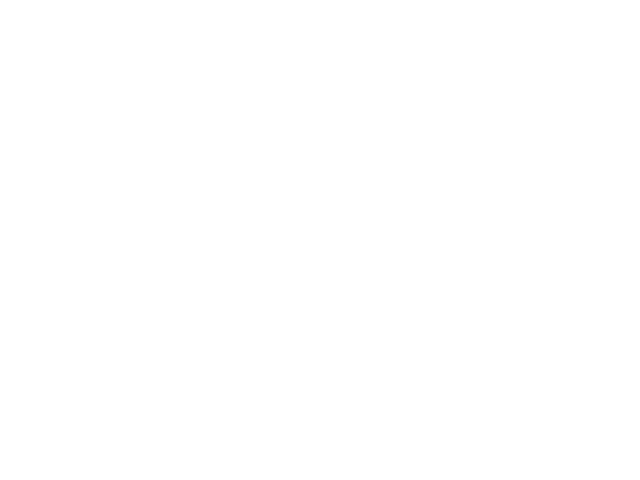

... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: V1_JC097-20190617-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 230 of 276 responsive cells.
mean score: 0.66 (+/- 0.06)
mean score: 0.72 (+/- 0.06)
mean score: 0.88 (+/- 0.04)
mean score: 0.86 (+/- 0.05)
mean score: 0.86 (+

<IPython.core.display.Javascript object>


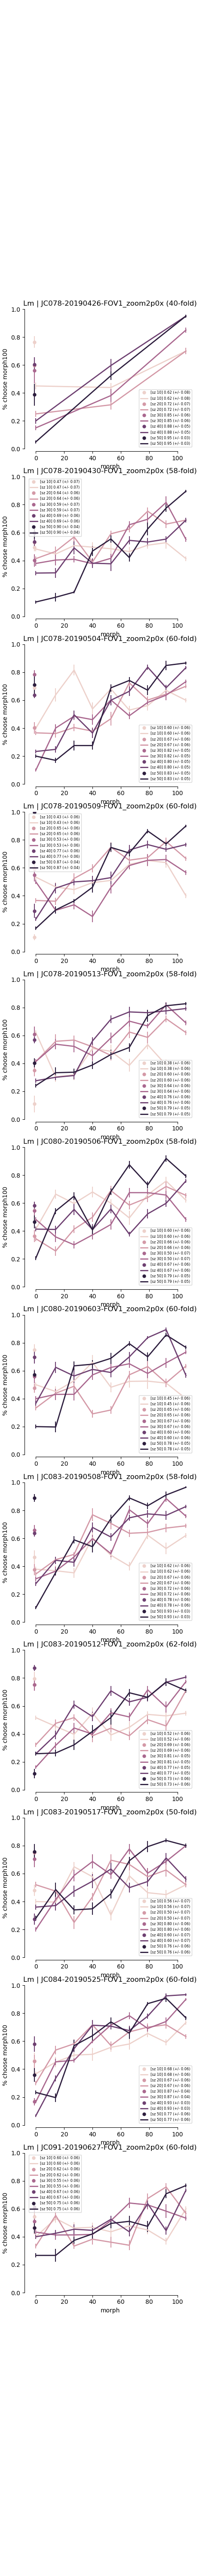

<IPython.core.display.Javascript object>


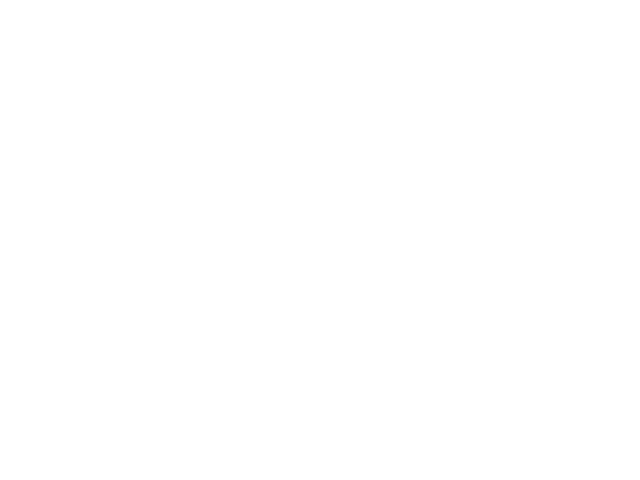

... [JC078|20190426|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190426-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 193 of 224 responsive cells.
mean score: 0.62 (+/- 0.08)
mean score: 0.72 (+/- 0.07)
mean score: 0.85 (+/- 0.06)
mean score: 0.88 (+/- 0.05)
mean score: 0.95 (+

<IPython.core.display.Javascript object>


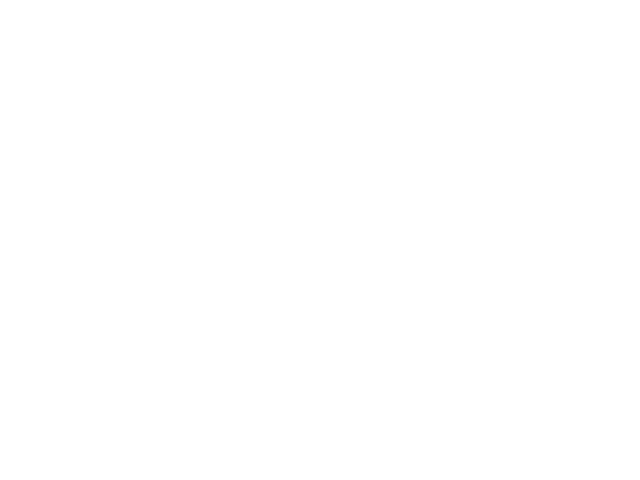

... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190430-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 150 of 185 responsive cells.
mean score: 0.47 (+/- 0.07)
mean score: 0.64 (+/- 0.06)
mean score: 0.59 (+/- 0.07)
mean score: 0.69 (+/- 0.06)
mean score: 0.90 (+

<IPython.core.display.Javascript object>


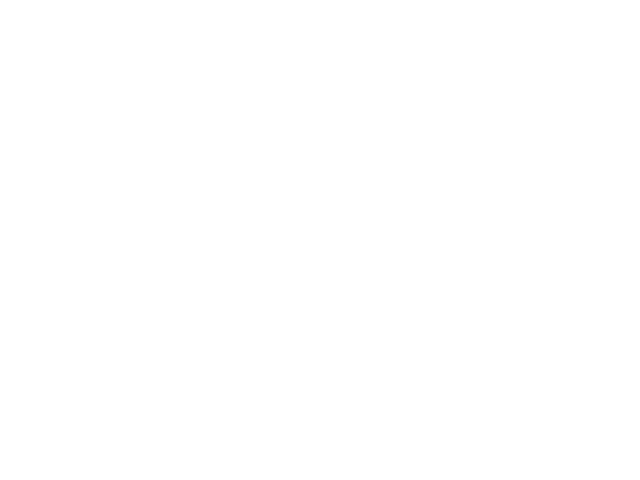

... [JC078|20190504|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190504-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 155 of 188 responsive cells.
mean score: 0.60 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.82 (+/- 0.05)
mean score: 0.80 (+/- 0.05)
mean score: 0.83 (+

<IPython.core.display.Javascript object>


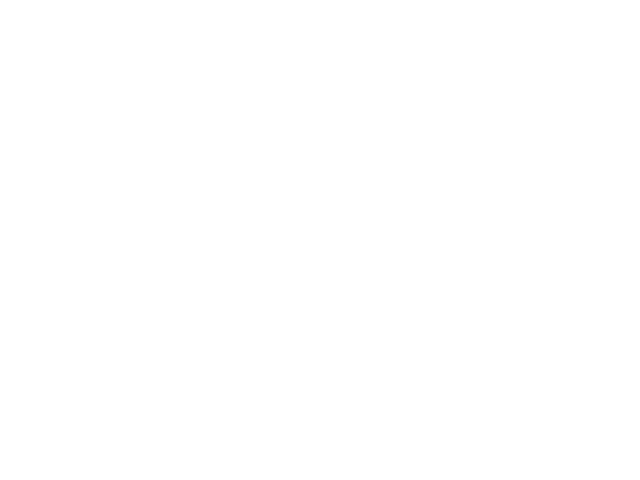

... [JC078|20190509|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190509-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 123 of 165 responsive cells.
mean score: 0.43 (+/- 0.06)
mean score: 0.65 (+/- 0.06)
mean score: 0.53 (+/- 0.06)
mean score: 0.77 (+/- 0.06)
mean score: 0.87 (+

<IPython.core.display.Javascript object>


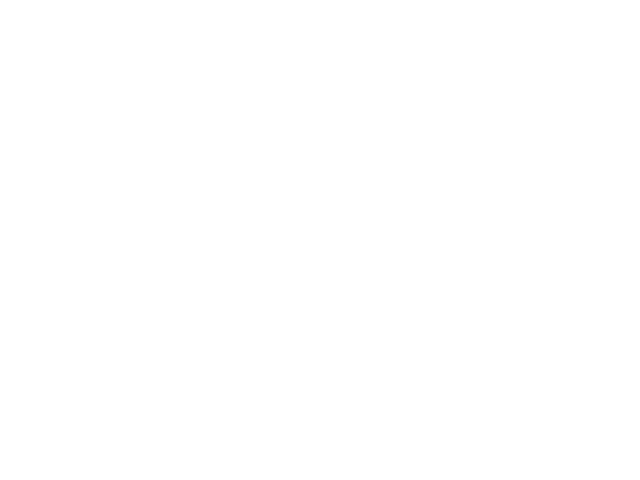

... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC078-20190513-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 138 of 177 responsive cells.
mean score: 0.38 (+/- 0.06)
mean score: 0.60 (+/- 0.06)
mean score: 0.64 (+/- 0.06)
mean score: 0.76 (+/- 0.06)
mean score: 0.79 (+

<IPython.core.display.Javascript object>


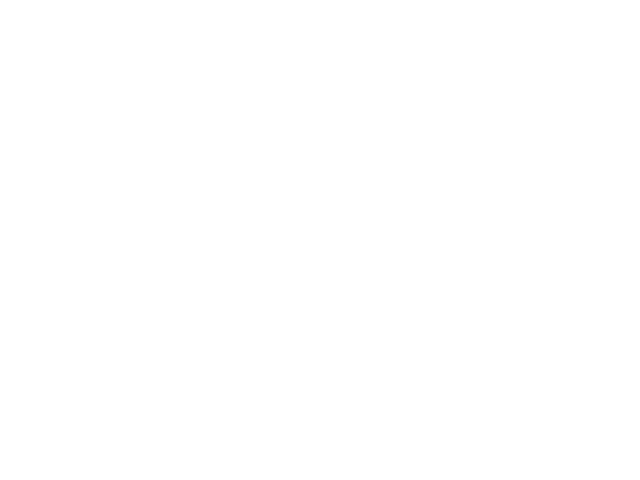

... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC080-20190506-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 196 of 225 responsive cells.
mean score: 0.60 (+/- 0.06)
mean score: 0.66 (+/- 0.06)
mean score: 0.50 (+/- 0.07)
mean score: 0.67 (+/- 0.06)
mean score: 0.79 (+

<IPython.core.display.Javascript object>


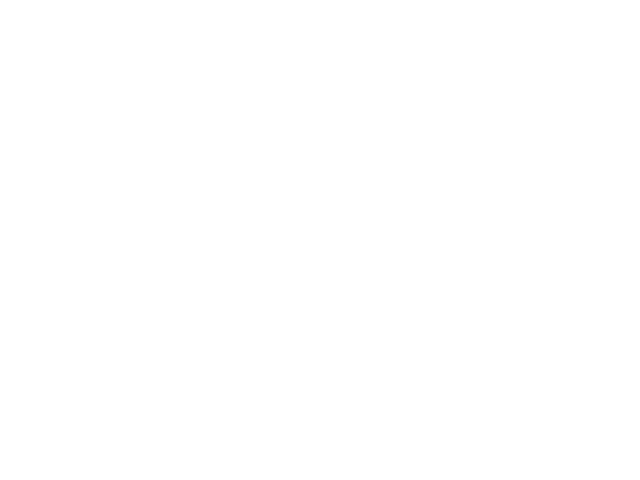

... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC080-20190603-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 167 of 226 responsive cells.
mean score: 0.45 (+/- 0.06)
mean score: 0.65 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.60 (+/- 0.06)
mean score: 0.78 (+

<IPython.core.display.Javascript object>


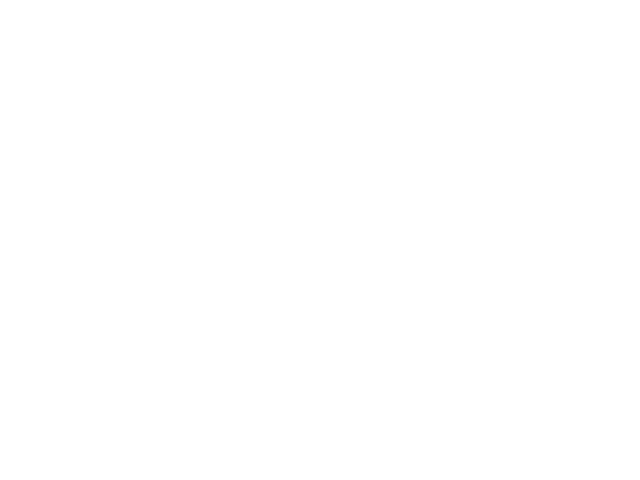

... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC083-20190508-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 127 of 171 responsive cells.
mean score: 0.62 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.72 (+/- 0.06)
mean score: 0.78 (+/- 0.06)
mean score: 0.93 (+

<IPython.core.display.Javascript object>


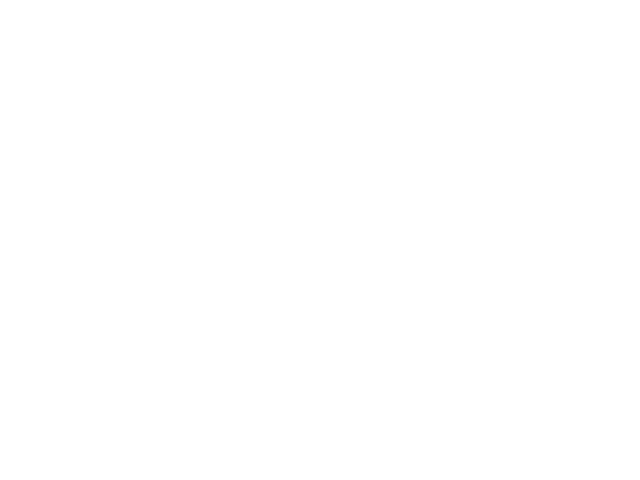

... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC083-20190512-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 148 of 266 responsive cells.
mean score: 0.52 (+/- 0.06)
mean score: 0.69 (+/- 0.06)
mean score: 0.81 (+/- 0.05)
mean score: 0.77 (+/- 0.05)
mean score: 0.73 (+

<IPython.core.display.Javascript object>


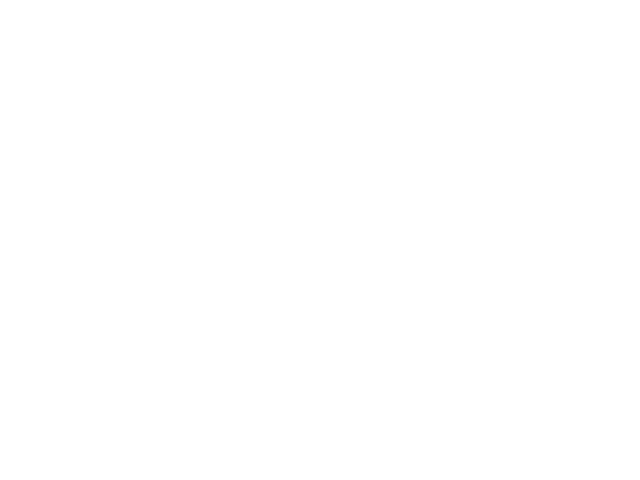

... [JC083|20190517|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC083-20190517-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 111 of 133 responsive cells.
mean score: 0.56 (+/- 0.07)
mean score: 0.50 (+/- 0.07)
mean score: 0.80 (+/- 0.06)
mean score: 0.60 (+/- 0.07)
mean score: 0.76 (+

<IPython.core.display.Javascript object>


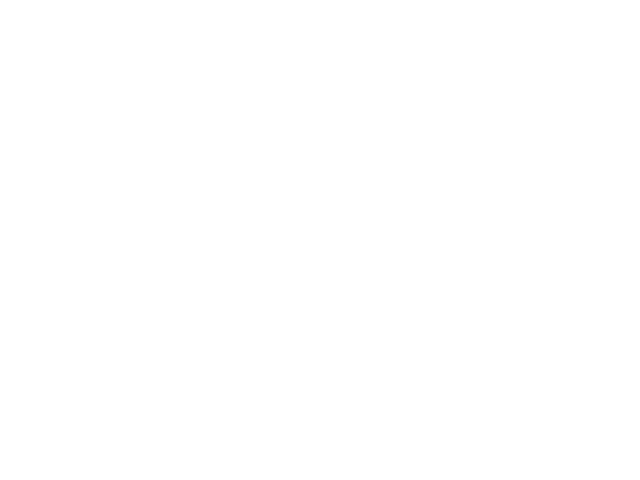

... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC084-20190525-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 143 of 160 responsive cells.
mean score: 0.68 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.87 (+/- 0.04)
mean score: 0.93 (+/- 0.03)
mean score: 0.77 (+

<IPython.core.display.Javascript object>


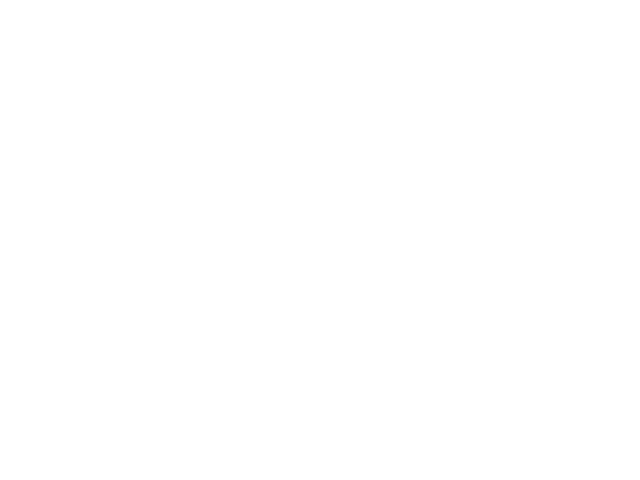

... [JC091|20190627|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Lm_JC091-20190627-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 155 of 170 responsive cells.
mean score: 0.60 (+/- 0.06)
mean score: 0.62 (+/- 0.06)
mean score: 0.55 (+/- 0.06)
mean score: 0.67 (+/- 0.06)
mean score: 0.75 (+

<IPython.core.display.Javascript object>


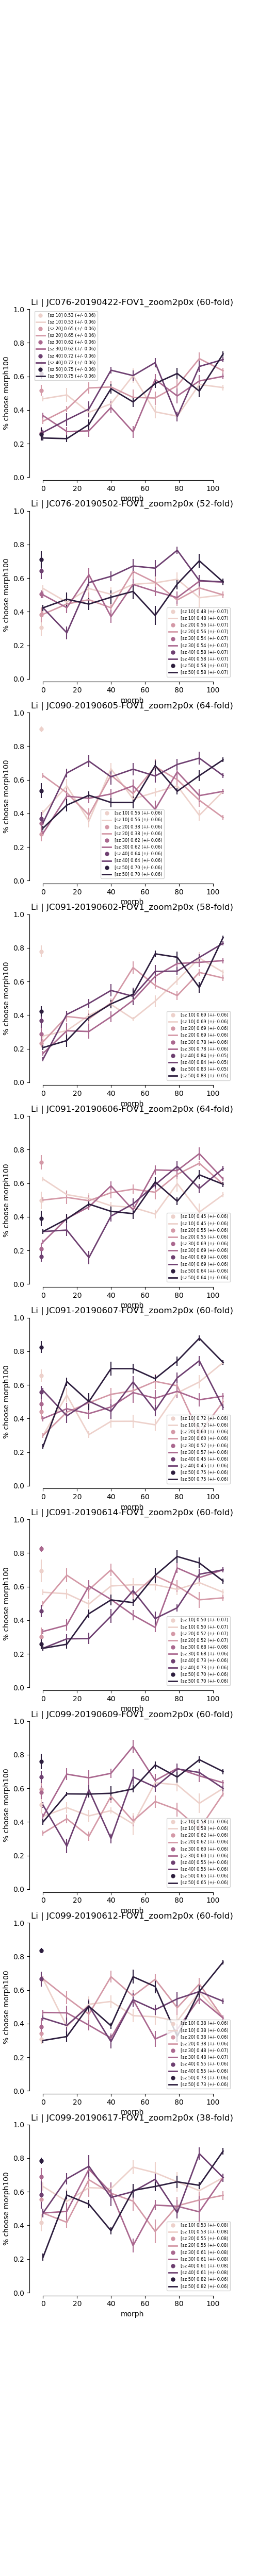

<IPython.core.display.Javascript object>


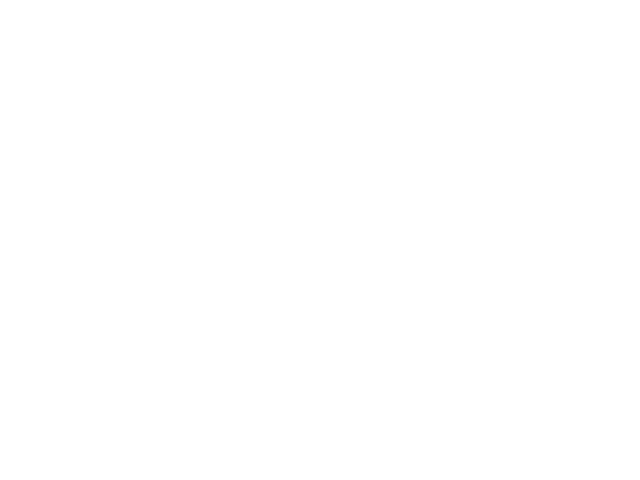

... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC076-20190422-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 168 of 228 responsive cells.
mean score: 0.53 (+/- 0.06)
mean score: 0.65 (+/- 0.06)
mean score: 0.62 (+/- 0.06)
mean score: 0.72 (+/- 0.06)
mean score: 0.75 (+

<IPython.core.display.Javascript object>


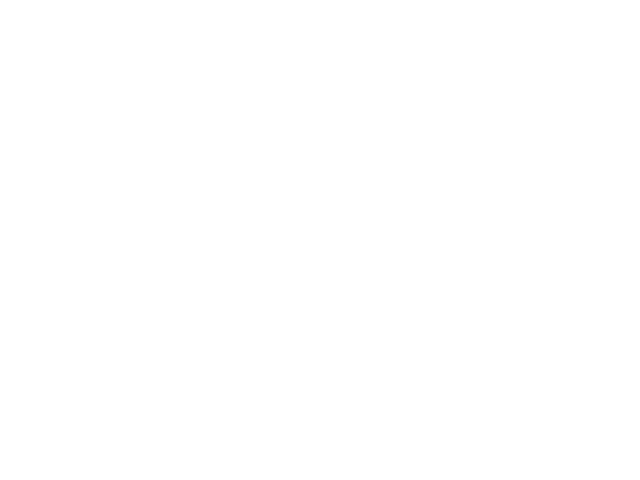

... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC076-20190502-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 126 of 148 responsive cells.
mean score: 0.48 (+/- 0.07)
mean score: 0.56 (+/- 0.07)
mean score: 0.54 (+/- 0.07)
mean score: 0.58 (+/- 0.07)
mean score: 0.58 (+

<IPython.core.display.Javascript object>


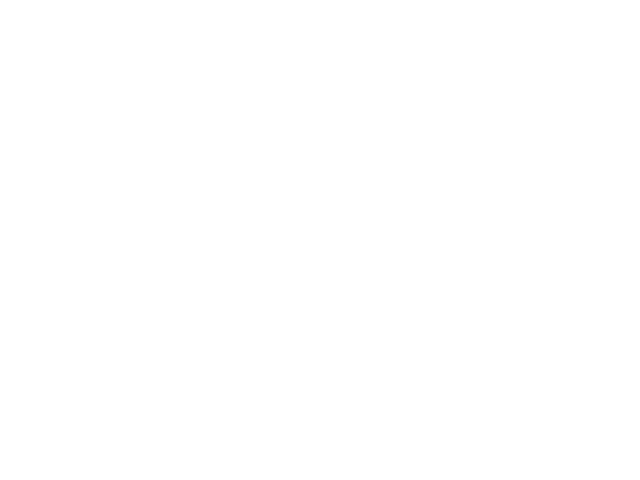

... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC090-20190605-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 142 of 161 responsive cells.
mean score: 0.56 (+/- 0.06)
mean score: 0.38 (+/- 0.06)
mean score: 0.62 (+/- 0.06)
mean score: 0.64 (+/- 0.06)
mean score: 0.70 (+

<IPython.core.display.Javascript object>


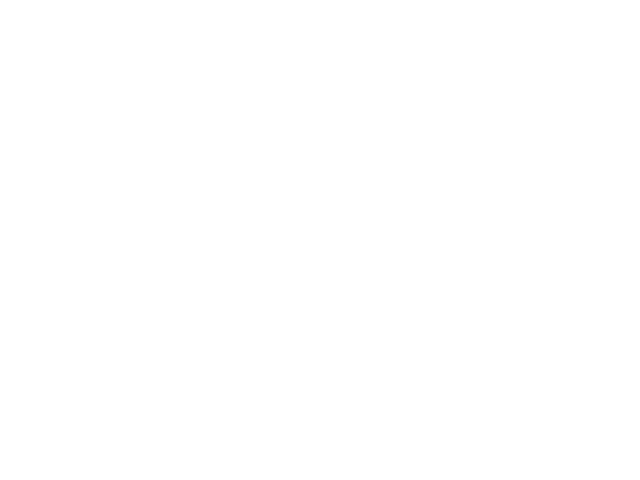

... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190602-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 233 of 284 responsive cells.
mean score: 0.69 (+/- 0.06)
mean score: 0.69 (+/- 0.06)
mean score: 0.78 (+/- 0.06)
mean score: 0.84 (+/- 0.05)
mean score: 0.83 (+

<IPython.core.display.Javascript object>


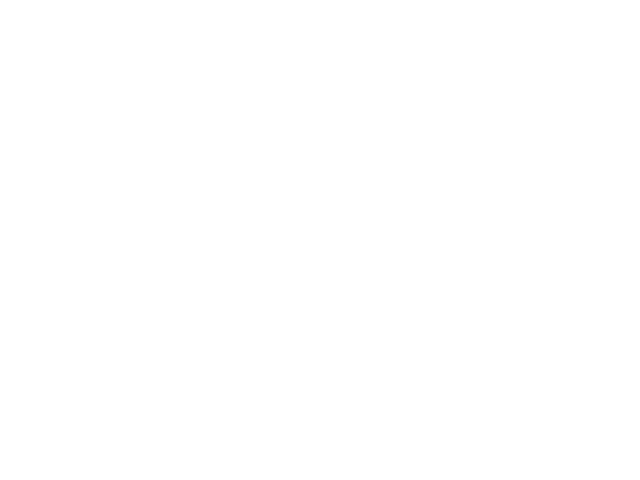

... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190606-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 115 of 134 responsive cells.
mean score: 0.45 (+/- 0.06)
mean score: 0.55 (+/- 0.06)
mean score: 0.69 (+/- 0.06)
mean score: 0.69 (+/- 0.06)
mean score: 0.64 (+

<IPython.core.display.Javascript object>


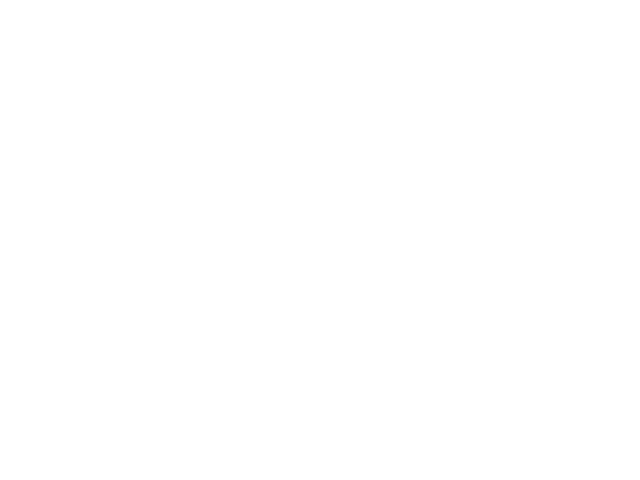

... [JC091|20190607|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190607-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 229 of 260 responsive cells.
mean score: 0.72 (+/- 0.06)
mean score: 0.60 (+/- 0.06)
mean score: 0.57 (+/- 0.06)
mean score: 0.45 (+/- 0.06)
mean score: 0.75 (+

<IPython.core.display.Javascript object>


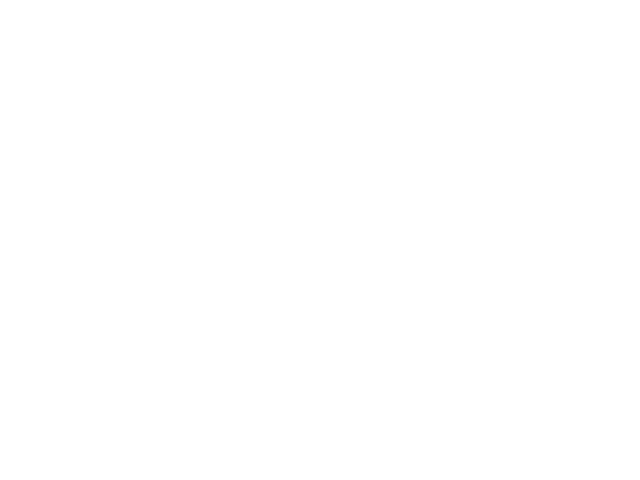

... [JC091|20190614|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC091-20190614-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 194 of 263 responsive cells.
mean score: 0.50 (+/- 0.07)
mean score: 0.52 (+/- 0.07)
mean score: 0.68 (+/- 0.06)
mean score: 0.73 (+/- 0.06)
mean score: 0.70 (+

<IPython.core.display.Javascript object>


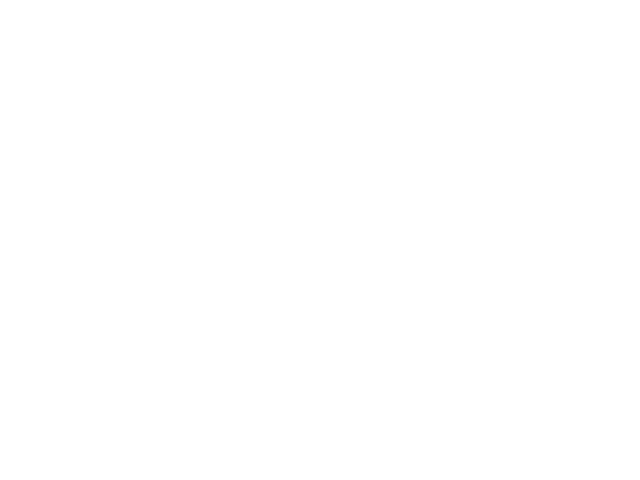

... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC099-20190609-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 84 of 126 responsive cells.
mean score: 0.58 (+/- 0.06)
mean score: 0.62 (+/- 0.06)
mean score: 0.60 (+/- 0.06)
mean score: 0.55 (+/- 0.06)
mean score: 0.65 (+/

<IPython.core.display.Javascript object>


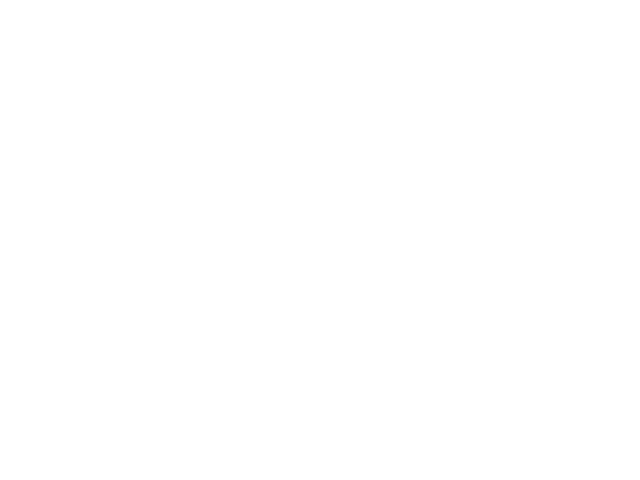

... [JC099|20190612|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC099-20190612-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 90 of 121 responsive cells.
mean score: 0.38 (+/- 0.06)
mean score: 0.38 (+/- 0.06)
mean score: 0.48 (+/- 0.07)
mean score: 0.55 (+/- 0.06)
mean score: 0.73 (+/

<IPython.core.display.Javascript object>


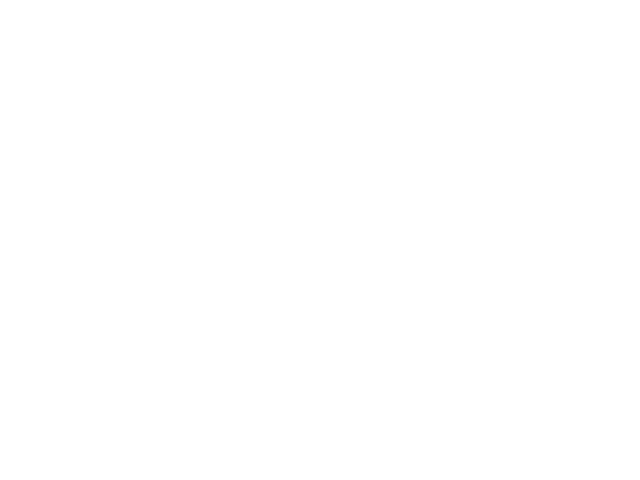

... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
          color morphlevel   object  size stimtype  xpos  ypos yrot
config001  0.08         -1  control  10.0    image  None  None    0
config002   0.2         -1  control  20.0    image  None  None    0
config003  0.32         -1  control  30.0    image  None  None    0
config004  0.44         -1  control  40.0    image  None  None    0
config005  0.56         -1  control  50.0    image  None  None    0
Timecourse: Li_JC099-20190617-FOV1_zoom2p0x_traces001-corrected.pkl
... [combined_blobs_static] Loading roi stats and cell list...
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 21 of 22 responsive cells.
mean score: 0.53 (+/- 0.08)
mean score: 0.55 (+/- 0.08)
mean score: 0.61 (+/- 0.08)
mean score: 0.61 (+/- 0.08)
mean score: 0.82 (+/-

In [56]:
results = dict((visual_area, dict()) for visual_area in visual_areas)

for visual_area in visual_areas:
    
    sessions = dsets[ dsets['visual_area'] == visual_area ]
    n_datasets = sessions.shape[0]
    
    thresh_str = 'thr-%.2f' % min_dff if threshold_dff else 'no-thr'
    sfilename = os.path.join(aggr_stats_dir, '%s_%s_%s-%s.pkl' % (visual_area, experiment_type, response_type, thresh_str))
    print("Stats: %s" % os.path.split(sfilename)[-1])
    try:
        with open(sfilename, 'rb') as f:
            allstats = pkl.load(f)
            #assert 'gdf' in estats
    except Exception as e:
        load_data = True
        allstats = {}
    print(allstats.keys())



    f2, axes = pl.subplots(n_datasets, figsize=(5, n_datasets*5))
    f2.patch.set_alpha(1)

    ai = 0
    #ai = 0
    for (animalid, session, fov), g in sessions.groupby(['animalid', 'session', 'fov']):
        ax2 = axes[ai]

        fig, ax = pl.subplots()
        fig.patch.set_alpha(1)

        skey = '-'.join([animalid, session, fov])
        data_id = '|'.join([animalid, session, fov, traceid, stats_desc])
        
        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)    
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        print sdf.head()
        tested_sizes = np.array(sorted(sdf['size'].unique()))
        tested_morphs = np.array(sorted(sdf['morphlevel'].unique()))

        sdf = reformat_morph_values(sdf)        
        n_sizes = len(tested_sizes)
        n_morphs = len(tested_morphs)
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            pass

        trace_desc = '%s_%s-%s' % (skey, traceid, trace_type)
        tfilename = os.path.join(aggr_tcourse_dir, '%s_%s.pkl' % (visual_area, trace_desc))
        print("Timecourse: %s" % os.path.split(tfilename)[-1])
        #load_data=False
        try:
            with open(tfilename, 'rb') as f:
                exp = pkl.load(f)
                assert exp.data is not None and 'traces' in dir(exp.data)
                sdf = exp.data.sdf.copy()
        except Exception as e:
            load_data = True

        sdf = reformat_morph_values(sdf)

        if load_data:
            # Get metrics for each condition
            estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
            with open(tfilename, 'wb') as f:
                pkl.dump(exp, f, protocol=pkl.HIGHEST_PROTOCOL)
            allstats[skey] = estats

        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T

        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        sample_data = pd.concat([pd.DataFrame(roidf[response_type].values, columns=[roi],
                                              index=roidf['config']) for roi, roidf in estats.gdf], axis=1)
        sample_data = sample_data[rois_plot]
        sample_labels = np.array(sample_data.index.tolist())


        #stimdf = sdf[sdf['morphlevel'] != -1]
        stimdf = sdf.copy()
        
        #% Specify train/test conditions:     
        class_name = 'morphlevel'
        class_types = [0, 106]
        restrict_transform = True
        constant_transform = 'size'

        C = 1e3
        m0 = 0
        m100 = 106
        #fig, ax = pl.subplots()

        size_colors = sns.cubehelix_palette(len(tested_sizes))
        lw=2
        pdict = dict()
        for curr_sz, curr_color in zip(tested_sizes, size_colors):

            if restrict_transform:
                constant_transform_val = curr_sz
                train_configs = stimdf[((stimdf[class_name].isin(class_types)) & (stimdf[constant_transform]==constant_transform_val))].index.tolist()
            else:
                train_configs = stimdf[stimdf[class_name].isin(class_types)].index.tolist()

            # Set train/test set:
            train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

            X = sample_data.iloc[train_ixs].values #[train_configs]
            y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

            # Set validation set:
            untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
            test_configs = stimdf[( (stimdf[constant_transform]==constant_transform_val) & (stimdf[class_name].isin(untrained_class_types)) )].index.tolist()
            test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
            X_test = sample_data.iloc[test_ixs].values
            y_test_labels = sample_labels[test_ixs]


            #% Train/test split
            n_splits = len(X)

            kf = KFold(n_splits=n_splits)
            kf.get_n_splits(X)

            scores=[]
            test_scores = dict((stimdf[class_name][tc], []) for tc in test_configs)
            choices = dict((tc, []) for tc in tested_morphs)

            for train_index, validate_index in kf.split(X):
                # Get current train/test split data:
                X_train, X_validate = X[train_index], X[validate_index]
                y_train, y_validate = y[train_index], y[validate_index]
                scaler = preprocessing.StandardScaler().fit(X_train)
                X_train_transformed = scaler.transform(X_train)

                # Fit SVM:
                trained_svc = LinearSVC(multi_class='ovr', C=C).fit(X_train_transformed, y_train)

                # Test:
                X_validate_transformed = scaler.transform(X_validate)
                curr_score = trained_svc.score(X_validate_transformed, y_validate)  
                y_pred = trained_svc.predict(X_validate_transformed)

                # Test 2:
                for true_val, pred_val in zip(y_validate, y_pred):
                    choices[true_val].append(pred_val)

                for tc in test_configs:
                    X_test_transformed = scaler.transform(X_test[np.where(y_test_labels==tc)[0], :])
                    curr_score_test = trained_svc.score(X_test_transformed, [m100 for _ in range(X_test_transformed.shape[0])])  
                    test_scores[stimdf[class_name][tc]].append(curr_score_test)
                    y_pred_test = trained_svc.predict(X_test_transformed)

                    choices[stimdf[class_name][tc]].append(y_pred_test)

                scores.append(curr_score)

            print("mean score: %.2f (+/- %.2f)" % (np.mean(scores), spstats.sem(scores)))
            #for k, v in sorted(test_scores.items(), key=lambda x: x[0]):
            #    print k, np.nanmean(v)

            #fig, ax = pl.subplots()
            pchoose100={}
            pchoose100_sem={}
            for k, v in choices.items():
                if k in [m0, m100]:
                    pchoose100[k] = np.mean(np.sum([i==m100 for i in v]) / float(len(v)))
                    pchoose100_sem[k] = np.std([i==m100 for i in v]) / float(len(v))
                else:
                    pchoose100[k] = np.mean([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])
                    pchoose100_sem[k] = np.std([np.sum([i==m100 for i in vv]) / float(len(vv)) for vv in v])

            curr_label = "[sz %i] %.2f (+/- %.2f)" % (curr_sz, np.mean(scores), spstats.sem(scores))
            for cax in [ax, ax2]:
                if -1 in pchoose100.keys():
                    cax.plot(sorted(pchoose100.keys())[0], [pchoose100[k] for k in sorted(pchoose100.keys())][0], 'o', \
                        markersize=5, lw=lw, color=curr_color, label=curr_label)
                    cax.errorbar(sorted(pchoose100.keys())[0], [pchoose100[k] for k in sorted(pchoose100.keys())][0],\
                            yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())][0], fmt='none',
                            ecolor=curr_color)

                    cax.plot(sorted(pchoose100.keys())[1:], [pchoose100[k] for k in sorted(pchoose100.keys())][1:], '-', \
                            markersize=.5, lw=lw, color=curr_color, label=curr_label)
                    cax.errorbar(sorted(pchoose100.keys())[1:], [pchoose100[k] for k in sorted(pchoose100.keys())][1:],\
                                yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())][1:], fmt='none',
                                ecolor=curr_color)
                else:
                    cax.plot(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())], '-', \
                            markersize=.5, lw=lw, color=curr_color, label=curr_label)
                    cax.errorbar(sorted(pchoose100.keys()), [pchoose100[k] for k in sorted(pchoose100.keys())],\
                                yerr=[pchoose100_sem[k] for k in sorted(pchoose100_sem.keys())], fmt='none',
                                ecolor=curr_color)
                
                cax.set_ylim([0, 1])
                cax.set_ylabel('% choose morph100')
                cax.set_xlabel('morph')
                cax.set_title('%s | %s (%i-fold)' % (visual_area, skey, n_splits))
                sns.despine(trim=True, offset=4, ax=cax)
            pdict['size_%i' % curr_sz] = {'mean': pchoose100, 'sem': pchoose100_sem}
            
        ax.legend(fontsize=6)
        ax2.legend(fontsize=6)

        pl.figure(fig.number)
        figname = '%s_%s_AvsB-linearSVM-LOO' % (visual_area, skey)
        pl.savefig(os.path.join(outdir, 'sessions', '%s.png' % figname))
        pl.close()
        ai += 1
        print figname
        
        results[visual_area][skey] = pdict
        
    pl.figure(f2.number)
    figname = '%s_AvsB-linearSVM-LOO_all-datasets' % (visual_area)
    pl.savefig(os.path.join(outdir, '%s.png' % figname))

    with open(sfilename, 'wb') as f:
        pkl.dump(allstats, f, protocol=pkl.HIGHEST_PROTOCOL)


In [73]:
skey

'JC097-20190617-FOV1_zoom2p0x'

In [108]:

dlist = []

for visual_area in visual_areas:
    for skey, pres in results[visual_area].items():
        for sz, res in pres.items():
            szval = int(sz.split('_')[-1])
            nmorphs = len(res['mean'].keys())
            animalid = skey.split('-')[0]
            session = skey.split('-')[1]
            fov = skey.split('-')[2]
            d= pd.DataFrame({'mean': [res['mean'][m] for m in sorted(res['mean'].keys())],
                         'sem': [res['sem'][m] for m in sorted(res['mean'].keys())],
                         'morph': sorted(res['mean'].keys()),
                         'size': [szval for _ in range(nmorphs)],
                          'animalid': [animalid for _ in range(nmorphs)],
                          'session': [session for _ in range(nmorphs)],
                          'fov': [fov for _ in range(nmorphs)],
                          'visual_area': [visual_area for _ in range(nmorphs)]})
            dlist.append(d)


In [109]:
probs = pd.concat(dlist, axis=0)


In [116]:
pchoose_grp = dict((visual_area, []) for visual_area in visual_areas)
for k, g in probs.groupby(['visual_area', 'animalid', 'session', 'fov']):
    if k[1]=='JC078' and k[2]=='20190426':
        continue
    print(k)
    arr = np.array([gg['mean'].values for sz, gg in g.groupby(['size'])])
    pchoose_grp[k[0]].append(arr)


('Li', 'JC076', '20190422', 'FOV1_zoom2p0x')
('Li', 'JC076', '20190502', 'FOV1_zoom2p0x')
('Li', 'JC090', '20190605', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190602', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190606', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190607', 'FOV1_zoom2p0x')
('Li', 'JC091', '20190614', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190609', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190612', 'FOV1_zoom2p0x')
('Li', 'JC099', '20190617', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190430', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190504', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190509', 'FOV1_zoom2p0x')
('Lm', 'JC078', '20190513', 'FOV1_zoom2p0x')
('Lm', 'JC080', '20190506', 'FOV1_zoom2p0x')
('Lm', 'JC080', '20190603', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190508', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190512', 'FOV1_zoom2p0x')
('Lm', 'JC083', '20190517', 'FOV1_zoom2p0x')
('Lm', 'JC084', '20190525', 'FOV1_zoom2p0x')
('Lm', 'JC091', '20190627', 'FOV1_zoom2p0x')
('V1', 'JC076', '20190420', 'FOV1_zoom2p0x')
('V1', 'JC

In [119]:
for visual_area, arr in pchoose_grp.items():
    pchoose_grp[visual_area] = np.dstack(arr)


In [127]:
tested_sizes = sorted(sdf['size'].unique())
tested_morphs = sorted(sdf['morphlevel'].unique())


In [162]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blob-classification/stats-traces001-corrected-dff-nstds-thr-10.00'

<IPython.core.display.Javascript object>


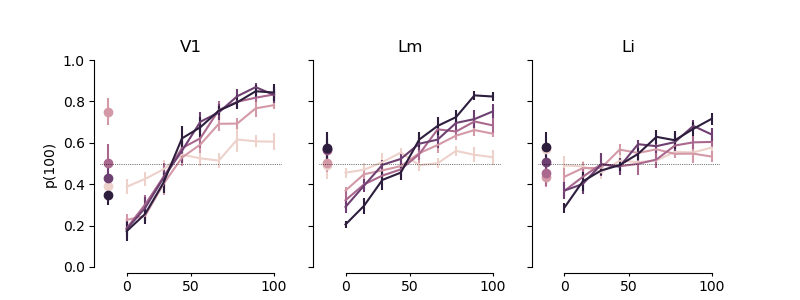

In [163]:
fig, axes = pl.subplots(1, 3, sharex=True, sharey=True, figsize=(8,3))
for ax, visual_area in zip(axes, visual_areas):
    arr = np.mean(pchoose_grp[visual_area], axis=-1)
    arr_sem = spstats.sem(pchoose_grp[visual_area], axis=-1)

    for si, sz in enumerate(tested_sizes):
        curr_color = size_colors[si]
        # plot control
        ax.plot(0, arr[si, 0], color=curr_color, marker='o')
        ax.errorbar(0, arr[si, 0],\
                        yerr=arr_sem[si, 0], fmt='none',
                        ecolor=curr_color)

        ax.plot(np.arange(1, len(tested_morphs)), arr[si, 1:], color=curr_color)
        ax.errorbar(np.arange(1, len(tested_morphs)), arr[si, 1:],\
                        yerr=arr_sem[si, 1:], fmt='none',
                        ecolor=curr_color)
    
    ax.set_ylim([0, 1])
    ax.set_title(visual_area)
    

for ai, ax in enumerate(axes):
    midp = (len(tested_morphs)-1)/2.
    ax.set_xticks([1, midp, len(tested_morphs)-1]) #range(len(tested_morphs)))
    ax.set_xticklabels([0, 50, 100])
    sns.despine(trim=True, offset=4)
    ax.axhline(y=0.5, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=2)
    if ai==0:
        ax.set_ylabel('p(100)')
        
pl.subplots_adjust(top=0.8)

pl.savefig(os.path.join(outdir, 'avg-pChoose100-LOO_by-visual-area.png'))

In [158]:
(len(tested_morphs)-1)/2.

4.5

In [93]:
choice_vals=dict((sz, []) for sz, gg in g.groupby(['size']))
for sz, gg in g.groupby(['size']):
    choice_vals[sz].append(gg['mean'].values)
    


In [94]:
choice_vals

{10: [array([0.4334126 , 0.31034483, 0.55350773, 0.65933413, 0.71284185,
         0.69976219, 0.65814507, 0.83115339, 0.68073722, 0.62068966])],
 20: [array([0.84661118, 0.27586207, 0.15398335, 0.23543401, 0.50237812,
         0.52615933, 0.77110583, 0.54577883, 0.61058264, 0.72413793])],
 30: [array([0.99940547, 0.17241379, 0.41022592, 0.6783591 , 0.78299643,
         0.82818074, 0.91914388, 0.75624257, 0.84185493, 0.93103448])],
 40: [array([0.63258026, 0.17241379, 0.28061831, 0.51426873, 0.6646849 ,
         0.89476813, 0.92627824, 0.93043995, 0.86206897, 0.89655172])],
 50: [array([0.26337693, 0.13793103, 0.17241379, 0.41498216, 0.67895363,
         0.73900119, 0.79785969, 0.7568371 , 0.79548157, 0.86206897])]}

In [97]:
np.array([gg['mean'].values for sz, gg in g.groupby(['size'])]).shape

(5, 10)

In [164]:
with open(os.path.join(outdir, 'pChoose100_results.pkl'), 'wb') as f:
    pkl.dump(probs, f, protocol=pkl.HIGHEST_PROTOCOL)